# Alveoli and acinar size
This [Jupyter](http://jupyter.com) contains the full analysis for the [publication on the acinar complexity](https://www.authorea.com/274247/47HwqAxume3L2xkLOsg_SQ).
All the (relevant) data, numbers and plots that are shown in the manuscript are calculated in this notebook.
Irrelevant data like total dataset size and other supporting materials are scattered into other notebooks in [the repository](http://github.com/habi/acinar-analysis) :)

First, let's set up the notebook.

In [1]:
# Load the modules we need
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import glob
import os
import pandas
import seaborn
import numpy
import scipy.stats
import itertools

In [2]:
# Style plots
seaborn.set_style('whitegrid')
seaborn.set_context('paper')

In [3]:
# Display all images in b&w and with no interpolation
plt.rc('image', cmap='gray', interpolation='none')
# Size up figures a bit
plt.rcParams['figure.figsize'] = (16 * 0.618, 9 * 0.618)
# Save (PNG) images with a higher DPI, since Authorea cannot import PDFs...
plt.rcParams['savefig.dpi'] = 300
# Despine all the plots (nearly equal to "seaborn.despine(offset=10, trim=True, bottom=True)")
plt.rc("axes.spines",
       top=False,
       right=False,
       bottom=False)

Define us some functions.

In [4]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [5]:
def significance(p):
    """
    Get some 'information' on the p-values we calculate.
    See the bottom of https://git.io/vQbWV
    """
    if p < 0.0001:
        return "**** (p=%0.2g)" % p
    elif (p < 0.001):
        return "*** (p=%0.2g)" % p
    elif (p < 0.01):
        return "** (p=%0.2g)" % p
    elif (p < 0.05):
        return "* (p=%0.2g)" % p
    else:
        return "n.s. (p=%0.2g)" % p

In [6]:
# Were are we?
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook.'
      % the_current_git_hash)

We are working with version f821590 of the analyis notebook.


In [7]:
# Make us an output folder
# Including the git hash, so we (potentially) have different versions of all the images we generate
OutputDir = os.path.join('Output', the_current_git_hash)
os.makedirs(OutputDir, exist_ok=True)

Now that we have set up everything, we load the data that we'll deal with.
First we load the 'Count' data from Eveline.
This is what she assessed with the [STEPanizer](https://www.stepanizer.com/) in tedious work.

In [8]:
# Different locations if running either on Linux or Windows
# ----
# We copied all the data from the external drives 'nas_schittny' and 'anatera4' to the internal 'fast SSD' with
# ---
# rsync -av -m --include='**/' --include='**/*5slices/**' --exclude='*' '/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/' '/media/habi/Fast_SSD/Acini/'
# (obviously only works on Linux)
# ---
# so we can set
FastSSD = True
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        RootPath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'Acini')
    else:
        RootPath = os.path.join(os.sep, 'home', 'habi', 'nas_gruppe_schittny', 'doc', 'David')
else:
    if FastSSD:
        RootPath = os.path.join('F:/', 'Acini')
    else:
        RootPath = os.path.join('\\\\nas.ana.unibe.ch\\', 'gruppe_schittny', 'Data', 'doc', 'David')
print('We are loading all the data from %s' % RootPath)

We are loading all the data from /media/habi/Fast_SSD/Acini


In [9]:
# Get a list of *all* excel files that Eveline exported from the STEPanizer
# Fortunately, she did NOT count in 2018
# Based on https://stackoverflow.com/a/14798263
StepanizerFiles_Eveline = sorted(glob.glob(os.path.join(RootPath, '**/*201[1234567]*.xls'), recursive=True))
if len(StepanizerFiles_Eveline):
    print('Eveline counted the alveoli in %s acini in total.' % len(StepanizerFiles_Eveline))
else:
    print('Mount the fast SSD please!!!')

Eveline counted the alveoli in 287 acini in total.


In [10]:
# Generate a dataframe for Evelines data
Eveline = pandas.DataFrame({'Location': StepanizerFiles_Eveline})
# Extract the relevant data from filenames
Eveline['Filename'] = [os.path.basename(f) for f in StepanizerFiles_Eveline]
Eveline['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_Eveline]
Eveline['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_Eveline]
Eveline['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_Eveline]
Eveline['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_Eveline]
Eveline['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_Eveline]
# Read the counts from the XLS files (which are just glorified CSV written by the STEPanizer)
Eveline['Counts'] = [int(pandas.read_csv(f, nrows=13, delimiter='\t')['Total'][10]) for f in StepanizerFiles_Eveline]
# Since we seem to have different tab-count in the files, we just read one single cell, explicitly...
Eveline['Pixelsize'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                              skiprows=16, header=None, usecols=[0, 1], nrows=1)[1][0])
                        for f in StepanizerFiles_Eveline]
# Count all the JPG images in their respective folders
Eveline['Number of images'] = [[int(os.path.basename(i).split('_')[-2]) for
                                i in glob.glob(os.path.join(os.path.dirname(location),
                                                            '*.jpg'))] for location in Eveline.Location]
Eveline['Number of images'] = [max(li) for li in Eveline['Number of images']]

In [11]:
# For D60, Eveline assessed the entrance rings on every second image, skipping every other
# We thus double the 'counts'
Eveline.loc[Eveline.Animal == '60B', 'Counts'] = 2 * Eveline['Counts']
# For Animal 60C she counted *every* image, we thus don't double there!
Eveline.loc[Eveline.Animal == '60D', 'Counts'] = 2 * Eveline['Counts']
Eveline.loc[Eveline.Animal == '60E', 'Counts'] = 2 * Eveline['Counts']
# For two acini (acinus 3 for 60D and acinus 12 for 60E) Eveline counted every image
Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 3), 'Counts'] = 0.5 * Eveline['Counts']
Eveline.loc[(Eveline.Animal == '60E') & (Eveline.Acinus == 12), 'Counts'] = 0.5 * Eveline['Counts']
# The 'number of images' (read below) stays the same, since Eveline just skipped the images in STEPanizer!

Now load the data from Davids stereological assessment of the acinar volumes.
We simply forgot to tell Eveline to do the proper Cavaglieri estimation during the same time she counted the entrance rings.

In [12]:
# Get a list of *all* the excel files David counted to assess the disector volume
# Fortunately, David ONLY counted in 2018
StepanizerFiles_David = sorted(glob.glob(os.path.join(RootPath, '**/*2018*.xls'), recursive=True))
print('David assessed the disector volume in %s acini' % len(StepanizerFiles_David))

David assessed the disector volume in 287 acini


In [13]:
# These variables are used below to calculate the acinus volume from the stereological assessment.
DisectorThickness = 5    # slices
TOMCATPixelSize = 1.48   # um

In [14]:
# Generate a dataframe for Davids data
David = pandas.DataFrame({'Location': StepanizerFiles_David})
# Extract the relevant data from filenames
David['Filename'] = [os.path.basename(f) for f in StepanizerFiles_David]
David['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_David]
David['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_David]
David['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_David]
David['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_David]
David['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_David]
# Read the files
David['Counts'] = [int(pandas.read_csv(f, nrows=13,
                                       delimiter='\t')['Total'][10]) for f in StepanizerFiles_David]
David['Pixelsize'] = [float(pandas.read_csv(f, skiprows=16, nrows=1, delimiter='\t', encoding='latin',
                                            header=None, usecols=[1])[1]) for f in StepanizerFiles_David]
# Calculate the volume of the acini
# Area per point in xls files in um^2
David['Area per point'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=28, header=None, usecols=[0, 1],
                                                 nrows=1)[1][0]) for f in StepanizerFiles_David]
# Acinusvol is in um^3, we go from um^3 to mm^3: https://encrypted.google.com/search?&q=cubic+micrometer+to+cubic+millimeter
David['Volume_Acinus_STEPanizer'] = [cts * ap * 2 * DisectorThickness * TOMCATPixelSize * 1e-9
                                     for cts, ap in zip(David['Counts'],
                                                        David['Area per point'])]
# Read the number of images from the xls-file instead of counting from disk
# Might be good for error-checking...
David['Number of images'] = [int(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=12, header=None, usecols=[0, 1, 2, 3],
                                                 nrows=1)[2][0][2:])  # Stefan writes '->NumImg' into the cell, so we read only everything from string position 3 on...
                             for f in StepanizerFiles_David]

In [15]:
# Merge 'Eveline' and 'David' dataframes to one
# Based on https://stackoverflow.com/a/33350050/323100
Done = pandas.merge(Eveline, David,
                    on=['Animal', 'Acinus', 'Day', 'Beamtime', 'Sample'],
                    how='inner', suffixes=['_Eveline', '_David'],
                    indicator=True)
print('We now have merged data (from Eveline and David) for %s acini...' % len(Done))

We now have merged data (from Eveline and David) for 287 acini...


Now load the acinar volumes, which were written to the DICOM files with MeVisLab a long time ago.
These are the volumes from the segmentation, so they are 'biased' in terms of thresholding difficulties.
We load the file names directly from `anatera4`, where I originally exported the DICOM files from MeVisLab (and where the data still is).
Since looking for all the DICOM files takes nearly an hour, we save the results to a dataframe on disk an load this dataframe if needed/wanted.

In [16]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    location_volumes = '/run/user/1000/gvfs/smb-share:server=anatera4,share='
else:
    location_volumes = '\\\\anatera4\\'
# Load the data from this folder
terastation = location_volumes + os.path.join('share', 'SLS')
print('We are loading all the data from %s' % terastation)

We are loading all the data from /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS


In [17]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Volumes = 'VolumesFromDisk_' + get_git_hash() + '.pkl'

In [18]:
# If we already ran the file loading recently, then there's an intermediate file we can use
# Thre process otherwise takes nearly an hour...
try:
    # Use the *freshest* VolumesFromDisk file, even if it's from another git hash
    OutputName_Volumes = max(glob.iglob('VolumesFromDisk*.pkl'), key=os.path.getctime)
except ValueError:
    print('We *need* to generate a new volume file, since we found none...')

In [19]:
if get_git_hash() != os.path.splitext(OutputName_Volumes.split('_')[1])[0]:
    print('The current git hash (%s) of our notebook is not the same as "OutputName_Volumes" (%s).' % (get_git_hash(), OutputName_Volumes))
    print('We are using the old file: %s' % OutputName_Volumes)
else:
    print('Hash (%s) is equal to the name of the OutputName_Volumes file name (%s).' % (get_git_hash(), OutputName_Volumes))

The current git hash (f821590) of our notebook is not the same as "OutputName_Volumes" (VolumesFromDisk_2ca705f.pkl).
We are using the old file: VolumesFromDisk_2ca705f.pkl


In [20]:
if os.path.exists(OutputName_Volumes):
    print('We loaded the volume data from %s' % OutputName_Volumes)
else:
    # Get a list of *all* DICOM files that I exported aeons ago
    # Based on https://stackoverflow.com/a/14798263
    # This takes between 30 and 60 minutes!
    # We thus only do it if we cannot read the dataframe with all the data saved from a previous run.
    print('We scan %s for "R108*.dcm" files' % terastation)
    tic = timeit.default_timer()
    AcinarVolumeFiles = sorted(glob.glob(os.path.join(terastation, '**/R108*.dcm'), recursive=True))
    toc = timeit.default_timer()
    print('We found %s DICOM files in %s minutes' % (len(AcinarVolumeFiles),
                                                     round(float((toc - tic) / 60.), 1)))

We loaded the volume data from VolumesFromDisk_2ca705f.pkl


In [21]:
# Collect the data into a dataframe
if os.path.exists(OutputName_Volumes):
    # We already did it once, so just load it...
    VolumesFromDisk = pandas.read_pickle(OutputName_Volumes)
else:
    # Save the file locations into an empty dataframe
    VolumesFromDisk = pandas.DataFrame({'Location_Volume': AcinarVolumeFiles})

In [22]:
# # Some names (see output of this cell) derive from the R108C$Day$$Animal$ scheme.
# # We catch them with the intricate .split() in the cells below...
# tmp = []
# for i in VolumesFromDisk.Location_Volume:
#     if len(i.split('mrg')[0][len('R108C'):-2]) >3:
#         tmp.append(i.split('mrg')[0][len('R108C'):-2])
# for i in pandas.unique(tmp):
#     print(i)

In [23]:
# Grab data from the file names
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk['Filename_Volume'] = [os.path.basename(f) for f in AcinarVolumeFiles]
    VolumesFromDisk['Animal'] = [os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C') + 3]
                                 for f in AcinarVolumeFiles]
    VolumesFromDisk['Beamtime'] = [os.path.dirname(f).split('SLS')[1].split(os.sep)[1]
                                   for f in AcinarVolumeFiles]
    VolumesFromDisk['Day'] = [int(os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C') + 2])
                              for f in AcinarVolumeFiles]
    VolumesFromDisk['Acinus'] = [int(os.path.basename(f).split('.acinus')[1].split('.volume')[0])
                                 for f in AcinarVolumeFiles]
    # According to the MeVisLab files, the volume is saved to the file name in 'ul'. Which is equal to mm^3
    VolumesFromDisk['Volume_Acinus_MeVisLab'] = [float(os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
                                                 for f in AcinarVolumeFiles]  # mm^3

In [24]:
# VolumesFromDisk.rename(index=str, columns={"Volume_MeVisLab": "Volume_Acinus_MeVisLab"}, inplace=True)

In [25]:
# Drop Day 36, which Eveline did not assess stereologically
# https://stackoverflow.com/a/27360130/323100
VolumesFromDisk.drop(VolumesFromDisk[VolumesFromDisk['Day'] == 36].index, inplace=True)
print('If we drop day 36, we now have the volume data for %s acini' % len(VolumesFromDisk))

If we drop day 36, we now have the volume data for 701 acini


In [26]:
# Save the data if it doesn't exist already
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk.to_pickle(OutputName_Volumes)

Now we merge the Eveline/David/Done and VolumesFromDisk dataframes to our one and final `Data` dataframe.

In [27]:
# Merge the dataframes: http://pandas.pydata.org/pandas-docs/stable/merging.html
# This discards all entries that are *not* found in both df's
Data = pandas.merge(Done, VolumesFromDisk, how='inner')

In [28]:
print('We now have merged data (Eveline/David/Volume) for %s acini...' % len(Data))

We now have merged data (Eveline/David/Volume) for 287 acini...


In [29]:
# Doublecheck that we merged to equal data
# If there's no output we're all good :)
for i, row in Done.iterrows():
    if Done.iloc[i].Acinus != Data.iloc[i].Acinus:
        print(i)
        print(Done.iloc[i].Sample, Done.iloc[i].Acinus)
        print(Data.iloc[i].Sample, Data.iloc[i].Acinus)
        print(80 * '*')

----

# Analysis
Not that we loaded all the data, we analyze and display it.

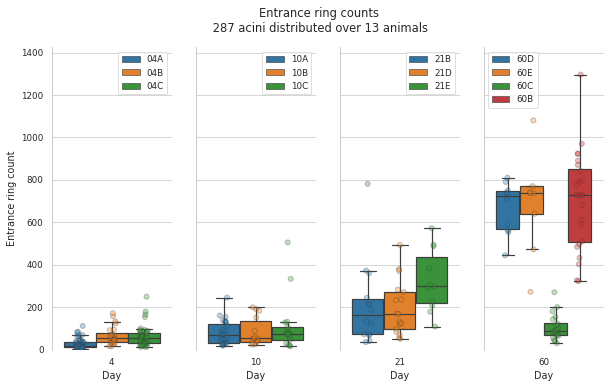

In [30]:
# Let's look at all the counts from Eveline
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, len(pandas.unique(Data.Day)), c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Counts_Eveline',
                            hue='Animal',
                            fliersize=0)
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Counts_Eveline',
                                hue='Animal',
                                jitter=True,
                                dodge=True,
                                linewidth=1,
                                alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Data.Counts_Eveline.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2])
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Entrance ring count')
plt.suptitle('Entrance ring counts\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                 len(pandas.unique(Data.Animal))))
plt.show()

What's wrong with sample 60C?
Let's test if it is different to the others of day 60!

In [31]:
# With help from Fluri
print('A T-test of day 60C against the others gives a difference with', end=' ')
t_statistic, p_value = scipy.stats.ttest_ind([numpy.mean(Data.loc[Data.Animal == '60C'].Counts_Eveline),
                                              numpy.mean(Data.loc[Data.Animal == '60C'].Counts_Eveline),
                                              numpy.mean(Data.loc[Data.Animal == '60C'].Counts_Eveline)],
                                             [numpy.mean(Data.loc[Data.Animal == '60B'].Counts_Eveline),
                                              numpy.mean(Data.loc[Data.Animal == '60D'].Counts_Eveline),
                                              numpy.mean(Data.loc[Data.Animal == '60E'].Counts_Eveline)])

print('a significance of %s.' % significance(p_value))

A T-test of day 60C against the others gives a difference with a significance of **** (p=8.1e-06).


In [32]:
# Based on the statiscial reasoning above, we can thus drop day 60C
Data.drop(Data[Data['Animal'] == '60C'].index,
          inplace=True)
print('After dropping day 60C, we have %s acini in our analysis' % len(Data))

After dropping day 60C, we have 267 acini in our analysis


In [33]:
# Since we do multiple comparisons, we have to apply a correction to the p_value
# The Bonferroni-correction is well known, but the Šidák is mathematically more correct, even if it's slightly less stringent.
# https://en.wikipedia.org/wiki/%C5%A0id%C3%A1k_correction
# For x null hyptheses, we have a sidak-corrected p_value of p_sidak = 1-(1-p_value)^(1/x)
sidak = 1 - (1 - 1 / 100) ** (1 / len(list(itertools.combinations(sorted(Data.Day.unique()), 2))))
print('The Šidák-corrected p-value for significance we use is %0.3e' % sidak)
bonferroni = 1 / 100 / len(list(itertools.combinations(sorted(Data.Day.unique()), 2)))
print('(Bonferroni-corrected, it would be %0.3e)' % bonferroni)

The Šidák-corrected p-value for significance we use is 1.674e-03
(Bonferroni-corrected, it would be 1.667e-03)


## Entrance ring count

In [34]:
# Describe the counts per day
Data.groupby(by=['Day'])['Counts_Eveline'].describe()[['count',
                                                       'mean',
                                                       'std',
                                                       'min',
                                                       'max']]

,count,mean,std,min,max
Day,,,,,
4,124.0,47.854839,41.279278,4.0,249.0
10,58.0,88.534483,83.843257,15.0,505.0
21,42.0,233.333333,164.301280,35.0,781.0
60,43.0,701.790698,219.109188,272.0,1296.0


In [35]:
# Describe the counts per day (for Authorea copy-pasting)
print('The mean count (alveolar number)')
for d in sorted(Data.Day.unique()):
    print('\t- for %s acini at day %s is %0.2f +- %0.2f' % (len(Data.loc[Data.Day == d]['Counts_Eveline']),
                                                            d,
                                                            Data.loc[Data.Day == d]['Counts_Eveline'].mean(),
                                                            Data.loc[Data.Day == d]['Counts_Eveline'].std()))

The mean count (alveolar number)
	- for 124 acini at day 4 is 47.85 +- 41.28
	- for 58 acini at day 10 is 88.53 +- 83.84
	- for 42 acini at day 21 is 233.33 +- 164.30
	- for 43 acini at day 60 is 701.79 +- 219.11


In [36]:
# Describe the counts per day and animal
Data.groupby(by=['Day', 'Animal'])['Counts_Eveline'].describe()

count        mean         std    min     25%    50%     75%  \
Day Animal                                                                
4   04A      50.0   27.040000   23.687558    4.0   11.25   17.5   35.00   
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00   
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00   
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00   
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25   
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00   
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00   
    21D      17.0  196.000000  128.564672   50.0   97.00  167.0  271.00   
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50   
60  60B      24.0  701.750000  230.946116  322.0  506.50  728.0  849.00   
    60D      10.0  668.300000  121.669909  444.0  569.25  722.0  747.00   
    60E       9.0  739.111111  281.215418  272.0  640.00  738.0  770.00   

               max  
Day Animal          
4   04A      111.0  
    04B      171.0  
    04C      249.0  
10  10A      245.0  
    10B      199.0  
    10C      505.0  
21  21B      781.0  
    21D      493.0  
    21E      572.0  
60  60B     1296.0  
    60D      810.0  
    60E     1204.0

In [37]:
# Save the counts per animal to CSV (for an Authorea table)
outfile = 'authorea_counts.csv'
out = Data.groupby(by='Animal')['Counts_Eveline'].describe()[['count',
                                                              'mean',
                                                              'std',
                                                              'min',
                                                              'max']]
# Force some columns to be 'int' for display reasons
# https://stackoverflow.com/a/28648923/323100
out = out.astype({'count': int, 'min': int, 'max': int})
out.to_csv(os.path.join(OutputDir,
                        outfile),
           float_format='%0.2f',
           header=['Assessed acini',
                   'Average',
                   'STD',
                   'Minimum',
                   'Maximum'])
print('\nSaved counts to',
      os.path.join(OutputDir, outfile))


Saved counts to Output/f821590/authorea_counts.csv


In [38]:
# Normalize the counts to the biggest count per animal
Data['Counts_Eveline_normalized'] = numpy.nan
for c, row in Data.iterrows():
    Data.loc[c, 'Counts_Eveline_normalized'] = row.Counts_Eveline / numpy.nanmax(Data.loc[Data.Animal == row.Animal].Counts_Eveline)

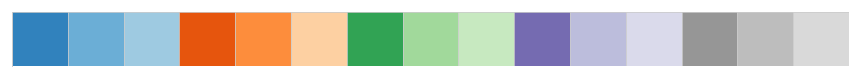

In [39]:
# Hack ourselves a qualitative color map, based on the individual unique sample names, but rather equal for the days
# First we get a colormap that has some regions (and expand it a bit, so we get 3 items per regions
# Based on https://stackoverflow.com/a/39808980/323100
x = numpy.linspace(0, 1, len(Data.Animal.unique()) + 3)
ourcolors = plt.cm.tab20c(x)
# That's the palette we get. We use the first 12 values of it
seaborn.palplot(ourcolors)
# Set it as a dictionary
# based on the comments in https://stackoverflow.com/q/36554075/323100
ourpalette = {animal: ourcolors[c] for c, animal in enumerate(sorted(pandas.unique(Data.Animal)))}

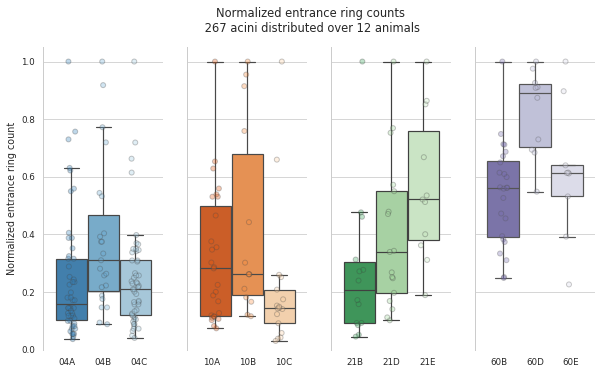

In [40]:
# Let's look at the counts from Eveline
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, len(pandas.unique(Data.Day)), c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                               x='Day',
                               y='Counts_Eveline_normalized',
                               hue='Animal',
                               # Because the animals are preferentially sorted on the beamtime name, we have
                               # to jump through the hoop below and sort the hues on the 'Animal' in addition
                               # to what we did for Evelines counts where all the data is in *one* folder
                               # Just comment the next line to see the difference (a correct plot, but ugly sort :)
                               hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                               palette=ourpalette,
                               fliersize=0)
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Counts_Eveline_normalized',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
    plt.gca().get_legend().remove()
    plt.ylim([0, 1.05])
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3), sorted(Data[Data.Day == d].Animal.unique()))
    plt.xlabel('')
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Normalized entrance ring count')
plt.suptitle('Normalized entrance ring counts\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                 len(pandas.unique(Data.Animal))))
plt.show()

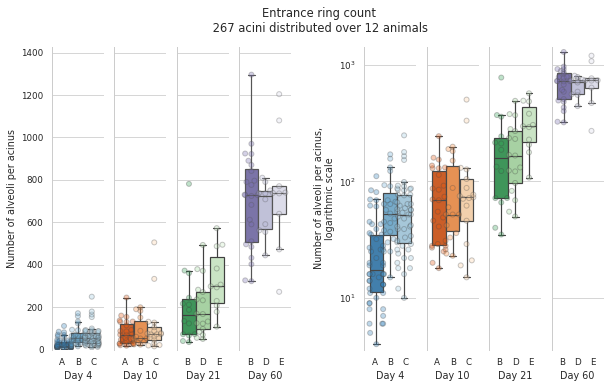

In [41]:
# Let's look at the counts from Eveline
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1,
                2 * len(pandas.unique(Data.Day)) + 1,
                c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Counts_Eveline',
                            hue='Animal',
                            # Because the animals are preferentially sorted on the beamtime name, we have
                            # to jump through the hoop below and sort the hues on the 'Animal' in addition
                            # to what we did for Evelines counts where all the data is in *one* folder
                            # Just comment the next line to see the difference (a correct plot, but ugly sort :)
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.swarmplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Counts_Eveline',
                                hue='Animal',
#                                 jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
    plt.gca().get_legend().remove()
    plt.ylim([0, 1.1 * Data.Counts_Eveline.max()])
    # Set xticks to only the animal denominator (the last item of the string
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               [animal[-1] for animal in sorted(Data[Data.Day == d].Animal.unique())])
    # Set the xlabel to the day
    plt.xlabel('Day %s' % d)
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Number of alveoli per acinus')

for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1,
                2 * len(pandas.unique(Data.Day)) + 1,
                len(pandas.unique(Data.Day)) + c + 2)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Counts_Eveline',
                            hue='Animal',
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.swarmplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Counts_Eveline',
                                hue='Animal',
#                                 jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
    plt.gca().get_legend().remove()
    plt.ylim([numpy.min(Data.Counts_Eveline.min()) * 0.9,
              numpy.max(Data.Counts_Eveline.max()) * 1.1])
    plt.gca().set_yscale('log')
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               [animal[-1] for animal in sorted(Data[Data.Day == d].Animal.unique())])
    plt.xlabel('Day %s' % d)
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Number of alveoli per acinus,\nlogarithmic scale')
plt.suptitle('Entrance ring count\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                       len(pandas.unique(Data.Animal))))
plt.savefig(os.path.join(OutputDir,
                         'Fig02-entrance-ring-count.png'))
plt.show()

In [42]:
# Are the 'entrance ring counts' normally distributed?
# Let's perform the Shapiro-Wilk test for normality.
print('The entrance ring coung for')
for animal in sorted(Data.Animal.unique()):
    w, p_value = scipy.stats.shapiro(Data[Data.Animal == animal]['Counts_Eveline'])
    if p_value < sidak:
        # Use the 'significance' function we defined at the start
        print('\t- animal %s (mean=%6.2f) are normally distributed (%s)' % (animal,
                                                                            numpy.mean(Data[Data.Animal == animal]['Counts_Eveline']),
                                                                            significance(p_value)))
    else:
        print('\t- animal %s (mean=%6.2f) are *not* normally distributed (%s)' % (animal,
                                                                                  numpy.mean(Data[Data.Animal == animal]['Counts_Eveline']),
                                                                                  significance(p_value)))

The entrance ring coung for
	- animal 04A (mean= 27.04) are normally distributed (**** (p=1.2e-06))
	- animal 04B (mean= 65.04) are *not* normally distributed (** (p=0.008))
	- animal 04C (mean= 60.51) are normally distributed (**** (p=8.3e-07))
	- animal 10A (mean= 77.85) are *not* normally distributed (** (p=0.0041))
	- animal 10B (mean= 84.57) are *not* normally distributed (** (p=0.0041))
	- animal 10C (mean=108.76) are normally distributed (**** (p=3.7e-05))
	- animal 21B (mean=208.14) are *not* normally distributed (** (p=0.0031))
	- animal 21D (mean=196.00) are *not* normally distributed (n.s. (p=0.1))
	- animal 21E (mean=323.09) are *not* normally distributed (n.s. (p=0.69))
	- animal 60B (mean=701.75) are *not* normally distributed (n.s. (p=0.47))
	- animal 60D (mean=668.30) are *not* normally distributed (n.s. (p=0.24))
	- animal 60E (mean=739.11) are *not* normally distributed (n.s. (p=0.6))


In [43]:
# Let's test if we can assume independent samples.
# For this we compute the Kruskal-Wallis H-test for independent samples
statisctic, p_value = scipy.stats.kruskal(Data[Data.Day == 4]['Counts_Eveline'],
                                          Data[Data.Day == 10]['Counts_Eveline'],
                                          Data[Data.Day == 21]['Counts_Eveline'],
                                          Data[Data.Day == 60]['Counts_Eveline'])
if p_value < sidak:
    print('The counts per volume per animal are independent (%s)' % significance(p_value))
else:
    print('We can *not* do what we do below :)')

The counts per volume per animal are independent (**** (p=2.2e-34))


Since at least one sample is non-normally distributed (see above), we use an [U-test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) for assessing the differences.
For this, we compute the two-sided Mann-Whitney rank test
In theory we should also test the variance, but since we have a non-normal distribution, we anyways need an U-test.

In [44]:
# Let's set ourselves up with an iterator to test all 6 possible combinations
combinations = itertools.combinations(sorted(Data.Day.unique()), 2)
# We have six combinations
worst_p = numpy.nan
for c, combination in enumerate(combinations):
    print('Testing combination %s:' % (c + 1), end=' ')
    print('Day {0[0]} versus day {0[1]}'.format(combination), end=' ')
    print('(means: %.f vs. %.f)' % (numpy.mean(Data[Data.Day == combination[0]]['Counts_Eveline']),
                                    numpy.mean(Data[Data.Day == combination[1]]['Counts_Eveline'])), end=' ')
    u, p_value = scipy.stats.mannwhitneyu(Data[Data.Day == combination[0]]['Counts_Eveline'],
                                          Data[Data.Day == combination[1]]['Counts_Eveline'],
                                          alternative='two-sided')
    if p_value < sidak:
        print('is significant (%s)' % significance(p_value))
        worst_p = numpy.nanmax((worst_p, p_value))
    else:
        print('is *not* significant (%s)' % significance(p_value))
print('\nThe worst p_value of all those is %0.2g' % worst_p)

Testing combination 1: Day 4 versus day 10 (means: 48 vs. 89) is significant (**** (p=2.5e-05))
Testing combination 2: Day 4 versus day 21 (means: 48 vs. 233) is significant (**** (p=2.8e-16))
Testing combination 3: Day 4 versus day 60 (means: 48 vs. 702) is significant (**** (p=1.7e-22))
Testing combination 4: Day 10 versus day 21 (means: 89 vs. 233) is significant (**** (p=7.3e-08))
Testing combination 5: Day 10 versus day 60 (means: 89 vs. 702) is significant (**** (p=2.3e-17))
Testing combination 6: Day 21 versus day 60 (means: 233 vs. 702) is significant (**** (p=6.7e-13))

The worst p_value of all those is 2.5e-05


----

## Acinar volumes
First, we explore the differences between the (old) method, where we just use the segmented volume from MeVisLab and the (new, more precise method) where we did a Cavalieri estimation of the voumes.

In [45]:
# In the original segmentation, we also include the ductal airspace.
# We correct for this, so we use data from Stefan and Lilian (Tschanz2014, Table 1) for a correction below.
DuctalToAlveolar = [0.133 / 0.486,
                    0.230 / 0.880,
                    0.594 / 1.910,
                    # 0.973 / 3.956,
                    1.292 / 5.645]

In [46]:
# In the original segmentation, we also include the ductal airspace.
# We correct for this, so we use data from Stefan and Lilian (Tschanz2014, Table 1) for a correction below.
TotalAirSpaceVolume_ST = [0.133 + 0.486,
                          0.230 + 0.880,
                          0.594 + 1.910,
                          # 0.973 + 3.956,
                          1.292 + 5.645]

In [47]:
print('MeVisLab Volumes\n')
# Give out alveolar volumes per day
for c, d in enumerate(sorted(Data.Day.unique())):
    print('Day %02d' % d)
    cts = numpy.mean(Data.loc[Data.Day == d]['Counts_Eveline'])
    print('Mean count from Eveline: %4.2f' % cts)
    # Acinus volume (*including* Ductus...), converted  from mm^3  to um^3
    # https://encrypted.google.com/search?hl=en&q=cubic%20millimeter%20to%20cubic%20micrometer
    vol = numpy.mean(Data.loc[Data.Day == d]['Volume_Acinus_MeVisLab']) * 1e9
    CorrectDuctal = False
    if CorrectDuctal:
        # Remove the ductal airspace, as assessed by Tschanz2014
        vol = vol - (DuctalToAlveolar[c] * vol)
    print('Mean volume per acinus (MeVisLab): %0.2f um^3' % vol)
    # Acinus size
    # Volume --> Radius
    # v = 4/3 * pi * r^3
    # r = ((3/4) * v / pi ) ^ 1/3
    # r * 2 = diameter
    print('Mean diameter of one acinus: %4.2f um' % (2 * (numpy.cbrt(3 / 4 * vol / numpy.pi))))
    # Alveolus volume and size
    print('Mean volume per alveolus: %0.2f um^3' % (vol / cts))
    print('Mean diameter of one alveolus: %4.2f um' % (2 * (numpy.cbrt(3 / 4 * (vol / cts) / numpy.pi))))
    print(80 * '-')
# https://www.wolframalpha.com/input/?i=sphere+with+volume+of+2.11e%2B08+ul

MeVisLab Volumes

Day 04
Mean count from Eveline: 47.85
Mean volume per acinus (MeVisLab): 20766292.82 um^3
Mean diameter of one acinus: 341.03 um
Mean volume per alveolus: 433943.43 um^3
Mean diameter of one alveolus: 93.93 um
--------------------------------------------------------------------------------
Day 10
Mean count from Eveline: 88.53
Mean volume per acinus (MeVisLab): 23326576.55 um^3
Mean diameter of one acinus: 354.50 um
Mean volume per alveolus: 263474.48 um^3
Mean diameter of one alveolus: 79.54 um
--------------------------------------------------------------------------------
Day 21
Mean count from Eveline: 233.33
Mean volume per acinus (MeVisLab): 58282535.23 um^3
Mean diameter of one acinus: 481.04 um
Mean volume per alveolus: 249782.29 um^3
Mean diameter of one alveolus: 78.14 um
--------------------------------------------------------------------------------
Day 60
Mean count from Eveline: 701.79
Mean volume per acinus (MeVisLab): 375346242.79 um^3
Mean diameter of

In [48]:
print('Stepanizered Volumes\n')
MeanAlveolarVolumeDavid = [None] * len(Data.Day.unique())
# Give out alveolar volumes per day
for c, d in enumerate(sorted(Data.Day.unique())):
    print('Day %02d' % d)
    cts = numpy.mean(Data.loc[Data.Day == d]['Counts_Eveline'])
    print('Mean count from Eveline: %0.2f' % cts)
    # Acinus Volume (*including* Ductus...), converted  from mm^3  to um^3
    # https://encrypted.google.com/search?hl=en&q=cubic%20millimeter%20to%20cubic%20micrometer
    vol = numpy.mean(Data.loc[Data.Day == d]['Volume_Acinus_STEPanizer']) * 1e9
    CorrectDuctal = False
    if CorrectDuctal:
        # Remove the ductal airspace, as assessed by Tschanz2014
        vol = vol - (DuctalToAlveolar[c] * vol)
    print('Mean volume (STEPanizer): %0.2f um^3' % vol)
    # Acinus size
    # Volume --> Radius
    # v = 4/3 * pi * r^3
    # r = ((3/4) * v / pi ) ^ 1/3
    # r * 2 = diameter
    print('Mean diameter of one acinus: %0.2f um' % (2 * (numpy.cbrt(3 / 4 * vol / numpy.pi))))
    # Alveolus volume and size
    MeanAlveolarVolumeDavid[c] = vol / cts
    print('Mean volume per alveolus: %0.2f um^3' % (MeanAlveolarVolumeDavid[c]))
    print('Mean diameter of one alveolus: %0.2f um' % (2 * (numpy.cbrt(3 / 4 * (vol / cts) / numpy.pi))))
    print(80 * '-')
# https://www.wolframalpha.com/input/?i=sphere+with+volume+of+2.11e%2B08+ul

Stepanizered Volumes

Day 04
Mean count from Eveline: 47.85
Mean volume (STEPanizer): 32857313.87 um^3
Mean diameter of one acinus: 397.38 um
Mean volume per alveolus: 686603.80 um^3
Mean diameter of one alveolus: 109.46 um
--------------------------------------------------------------------------------
Day 10
Mean count from Eveline: 88.53
Mean volume (STEPanizer): 40042854.92 um^3
Mean diameter of one acinus: 424.47 um
Mean volume per alveolus: 452285.41 um^3
Mean diameter of one alveolus: 95.24 um
--------------------------------------------------------------------------------
Day 21
Mean count from Eveline: 233.33
Mean volume (STEPanizer): 103920275.29 um^3
Mean diameter of one acinus: 583.31 um
Mean volume per alveolus: 445372.61 um^3
Mean diameter of one alveolus: 94.75 um
--------------------------------------------------------------------------------
Day 60
Mean count from Eveline: 701.79
Mean volume (STEPanizer): 739354555.29 um^3
Mean diameter of one acinus: 1121.89 um
Mean v

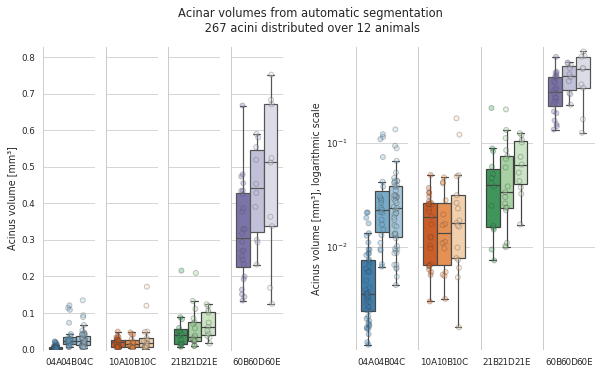

In [49]:
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, 2 * len(pandas.unique(Data.Day)) + 1, c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                               x='Day',
                               y='Volume_Acinus_MeVisLab',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                               palette=ourpalette,
                               fliersize=0,
                               )
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Volume_Acinus_MeVisLab',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                
                                alpha=0.309)
    plt.ylim([0, 1.1 * Data.Volume_Acinus_MeVisLab.max()])
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               sorted(Data[Data.Day == d].Animal.unique()))
    plt.xlabel('')
    plt.gca().get_legend().remove()
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Acinus volume [mm³]')
    plt.subplot(1,
                2 * len(pandas.unique(Data.Day)) + 1,
                len(pandas.unique(Data.Day)) + c + 2)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                               x='Day',
                               y='Volume_Acinus_MeVisLab',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                               palette=ourpalette,
                               fliersize=0,
                               )
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Volume_Acinus_MeVisLab',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                
                                alpha=0.309)
    plt.ylim([numpy.min(Data.Volume_Acinus_MeVisLab.min()) * 0.9,
              numpy.max(Data.Volume_Acinus_MeVisLab.max()) * 1.1])
    plt.gca().set_yscale('log')
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               sorted(Data[Data.Day == d].Animal.unique()))
    plt.xlabel('')
    plt.gca().get_legend().remove()
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Acinus volume [mm³], logarithmic scale')

plt.suptitle('Acinar volumes from automatic segmentation\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                       len(pandas.unique(Data.Animal))))
plt.savefig(os.path.join(OutputDir,
                         'volumes-mevislab.png'))
plt.show()

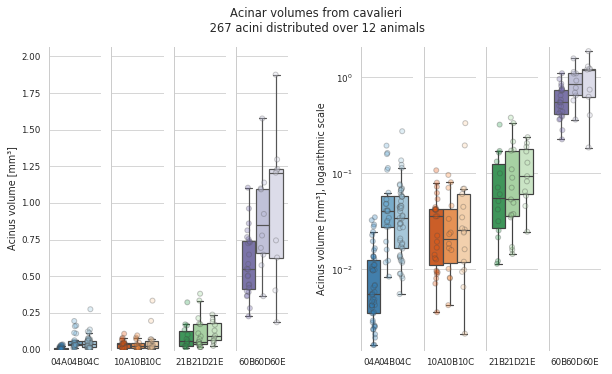

In [50]:
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, 2 * len(pandas.unique(Data.Day)) + 1, c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Volume_Acinus_STEPanizer',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                               palette=ourpalette,
                               fliersize=0,
                               )
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Volume_Acinus_STEPanizer',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                
                                alpha=0.309)
    plt.ylim([0, 1.1 * Data.Volume_Acinus_STEPanizer.max()])
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               sorted(Data[Data.Day == d].Animal.unique()))
    plt.xlabel('')
    plt.gca().get_legend().remove()
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Acinus volume [mm³]')
    plt.subplot(1, 2 * len(pandas.unique(Data.Day)) + 1,
                len(pandas.unique(Data.Day)) + c + 2)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                               x='Day',
                               y='Volume_Acinus_STEPanizer',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                               palette=ourpalette,
                               fliersize=0,
                               )
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Volume_Acinus_STEPanizer',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                
                                alpha=0.309)
    plt.ylim([numpy.min(Data.Volume_Acinus_STEPanizer.min()) * 0.9,
              numpy.max(Data.Volume_Acinus_STEPanizer.max()) * 1.1])
    plt.gca().set_yscale('log')
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               sorted(Data[Data.Day == d].Animal.unique()))
    plt.xlabel('')
    plt.gca().get_legend().remove()
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Acinus volume [mm³], logarithmic scale')

plt.suptitle('Acinar volumes from cavalieri\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                       len(pandas.unique(Data.Animal))))
plt.savefig(os.path.join(OutputDir,
                         'volumes-stepanizer.png'))
plt.show()

In [51]:
Data['Volume_Acinus_MeVisLab_normalized'] = numpy.nan
for c, row in Data.iterrows():
    Data.loc[c, 'Volume_Acinus_MeVisLab_normalized'] = row.Volume_Acinus_MeVisLab / numpy.nanmax(Data.loc[Data.Animal == row.Animal].Volume_Acinus_MeVisLab)

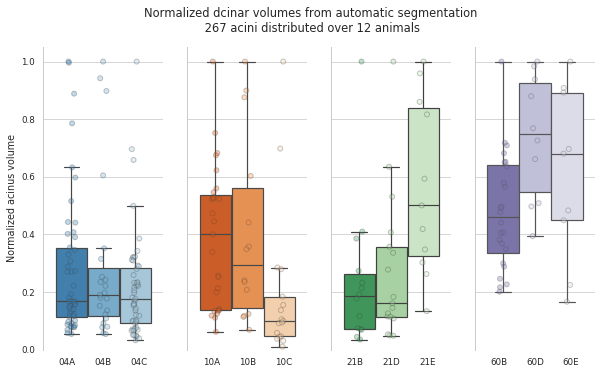

In [52]:
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, len(pandas.unique(Data.Day)), c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Volume_Acinus_MeVisLab_normalized',
                            hue='Animal',
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Volume_Acinus_MeVisLab_normalized',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
#     handles, labels = plt.gca().get_legend_handles_labels()
#     bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='upper right')
#     plt.legend('')
    plt.gca().get_legend().remove()
    plt.ylim([0, 1.05])
    plt.xlabel('')
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3), sorted(Data[Data.Day == d].Animal.unique()))
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Normalized acinus volume')
plt.suptitle('Normalized dcinar volumes from automatic segmentation\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                       len(pandas.unique(Data.Animal))))
plt.savefig(os.path.join(OutputDir,
                         'volumes-mevislab-normalized.png'))
plt.show()

----

## Acinus volumes
Describe the STEPanizered volumes

In [53]:
# Describe the volumes per day
Data.groupby(by=['Day'])['Volume_Acinus_STEPanizer'].describe()

,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
4,124.0,0.032857,0.041436,0.001628,0.007769,0.017752,0.041741,0.274707
10,58.0,0.040043,0.051252,0.002140,0.010600,0.024436,0.044755,0.333254
21,42.0,0.103920,0.093100,0.011432,0.036389,0.067926,0.167827,0.380460
60,43.0,0.739355,0.369607,0.185877,0.442245,0.692757,0.942985,1.874612


In [54]:
# Describe the volumes per day (for Authorea copy-pasting)
print('The mean acinus volume')
for d in sorted(Data.Day.unique()):
    print('\t- for %s acini at day %s is %0.2f mm^3 +- %0.2f' % (len(Data[Data.Day == d]['Volume_Acinus_STEPanizer']),
                                                                 d,
                                                                 Data[Data.Day == d]['Volume_Acinus_STEPanizer'].mean(),
                                                                 Data[Data.Day == d]['Volume_Acinus_STEPanizer'].std()))

The mean acinus volume
	- for 124 acini at day 4 is 0.03 mm^3 +- 0.04
	- for 58 acini at day 10 is 0.04 mm^3 +- 0.05
	- for 42 acini at day 21 is 0.10 mm^3 +- 0.09
	- for 43 acini at day 60 is 0.74 mm^3 +- 0.37


In [55]:
# Describe the volumes per day and animal
Data.groupby(by=['Day', 'Animal'])['Volume_Acinus_STEPanizer'].describe()

count      mean       std       min       25%       50%       75%  \
Day Animal                                                                      
4   04A      50.0  0.009375  0.008536  0.001628  0.003524  0.005583  0.012407   
    04B      23.0  0.058097  0.052507  0.008413  0.027847  0.040765  0.058280   
    04C      51.0  0.044496  0.044234  0.005535  0.016766  0.034275  0.057462   
10  10A      27.0  0.033345  0.025892  0.003583  0.011191  0.035619  0.042508   
    10B      14.0  0.032617  0.029625  0.004242  0.011577  0.020870  0.042937   
    10C      17.0  0.056795  0.084458  0.002140  0.012026  0.026002  0.060925   
21  21B      14.0  0.087002  0.086453  0.011432  0.027035  0.055999  0.124669   
    21D      17.0  0.108524  0.111635  0.014476  0.036162  0.053481  0.172666   
    21E      11.0  0.118337  0.072218  0.024664  0.061703  0.093533  0.179054   
60  60B      24.0  0.588268  0.222719  0.225961  0.415072  0.548137  0.741917   
    60D      10.0  0.888499  0.350353  0.363500  0.658514  0.850991  1.096984   
    60E       9.0  0.976536  0.526236  0.185877  0.627343  1.205916  1.230092   

                 max  
Day Animal            
4   04A     0.034906  
    04B     0.194415  
    04C     0.274707  
10  10A     0.107684  
    10B     0.096283  
    10C     0.333254  
21  21B     0.321820  
    21D     0.380460  
    21E     0.238156  
60  60B     1.103739  
    60D     1.575762  
    60E     1.874612

In [56]:
# Save the counts per animal to CSV (for an Authorea table)
outfile = 'authorea_volumes.csv'
out = Data.groupby(by='Animal')['Volume_Acinus_STEPanizer'].describe()[['count',
                                                                        'mean',
                                                                        'std',
                                                                        'min',
                                                                        'max']]
out = out.astype({'count': int})
out.to_csv(os.path.join(OutputDir, outfile),
           float_format='%0.3f',
           header=['Assessed acini',
                   'Average',
                   'STD',
                   'Minimum',
                   'Maximum'])
print('\nSaved the volume data to', os.path.join(OutputDir, outfile))


Saved the volume data to Output/f821590/authorea_volumes.csv


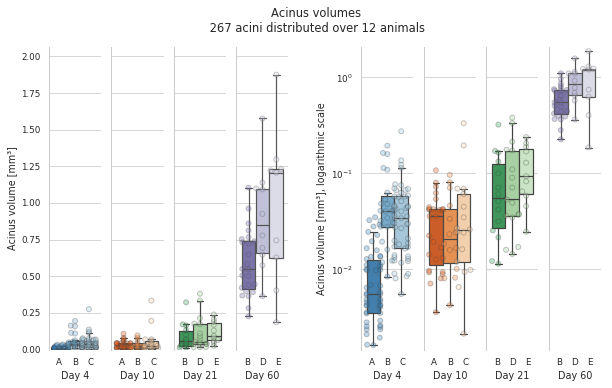

In [57]:
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, 2 * len(pandas.unique(Data.Day)) + 1, c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Volume_Acinus_STEPanizer',
                            hue='Animal',
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.swarmplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Volume_Acinus_STEPanizer',
                                hue='Animal',
#                                 jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
    plt.gca().get_legend().remove()
    plt.ylim([0, 1.1 * Data.Volume_Acinus_STEPanizer.max()])
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               [animal[-1] for animal in sorted(Data[Data.Day == d].Animal.unique())])
    plt.xlabel('Day %s' % d)
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Acinus volume [mm³]')
    plt.subplot(1, 2 * len(pandas.unique(Data.Day)) + 1, len(pandas.unique(Data.Day)) + c + 2)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Volume_Acinus_STEPanizer',
                            hue='Animal',
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.swarmplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Volume_Acinus_STEPanizer',
                                hue='Animal',
#                                 jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
    plt.gca().get_legend().remove()
    plt.ylim([numpy.min(Data.Volume_Acinus_STEPanizer.min()) * 0.9,
              numpy.max(Data.Volume_Acinus_STEPanizer.max()) * 1.1])
    plt.gca().set_yscale('log')
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               [animal[-1] for animal in sorted(Data[Data.Day == d].Animal.unique())])
    plt.xlabel('Day %s' % d)
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Acinus volume [mm³], logarithmic scale')
plt.suptitle('Acinus volumes\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                       len(pandas.unique(Data.Animal))))
plt.savefig(os.path.join(OutputDir,
                         'Fig03-volumes-disector.png'))
plt.show()

In [58]:
Data['Volume_Acinus_STEPanizer_normalized'] = numpy.nan
for c, row in Data.iterrows():
    Data.loc[c, 'Volume_Acinus_STEPanizer_normalized'] = row.Volume_Acinus_STEPanizer / numpy.nanmax(Data.loc[Data.Animal == row.Animal].Volume_Acinus_STEPanizer)

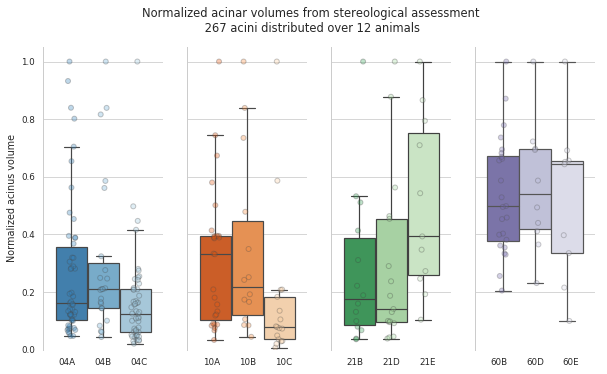

In [59]:
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, len(pandas.unique(Data.Day)), c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Volume_Acinus_STEPanizer_normalized',
                            hue='Animal',
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Volume_Acinus_STEPanizer_normalized',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
#     handles, labels = plt.gca().get_legend_handles_labels()
#     bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='upper right')
#     plt.legend('')
    plt.gca().get_legend().remove()
    plt.ylim([0, 1.05])
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3), sorted(Data[Data.Day == d].Animal.unique()))
    plt.xlabel('')
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Normalized acinus volume')
plt.suptitle('Normalized acinar volumes from stereological assessment\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                       len(pandas.unique(Data.Animal))))
plt.savefig(os.path.join(OutputDir,
                         'volumes-disector-normalized.png'))
plt.show()

In [60]:
# Are the volumes normally distributed?
# Let's perform the Shapiro-Wilk test for normality.
print('The acinar volumes for')
for animal in sorted(Data.Animal.unique()):
    w, p_value = scipy.stats.shapiro(Data[Data.Animal == animal]['Volume_Acinus_STEPanizer'])
    if p_value < 5 / 100:
        # Use the 'significance' function we defined at the start
        print('\t- animal %s (mean=%0.2g) are normally distributed (%s)' % (animal,
                                                                            numpy.mean(Data[Data.Animal == animal]['Volume_Acinus_STEPanizer']),
                                                                            significance(p_value)))
    else:
        print('\t- animal %s (mean=%0.2g) are non-normally distributed (%s)' % (animal,
                                                                                numpy.mean(Data[Data.Animal == animal]['Volume_Acinus_STEPanizer']),
                                                                                significance(p_value)))

The acinar volumes for
	- animal 04A (mean=0.0094) are normally distributed (**** (p=7.2e-07))
	- animal 04B (mean=0.058) are normally distributed (*** (p=0.00019))
	- animal 04C (mean=0.044) are normally distributed (**** (p=5.3e-09))
	- animal 10A (mean=0.033) are normally distributed (** (p=0.0053))
	- animal 10B (mean=0.033) are normally distributed (* (p=0.011))
	- animal 10C (mean=0.057) are normally distributed (**** (p=1.4e-05))
	- animal 21B (mean=0.087) are normally distributed (** (p=0.0072))
	- animal 21D (mean=0.11) are normally distributed (** (p=0.0016))
	- animal 21E (mean=0.12) are non-normally distributed (n.s. (p=0.43))
	- animal 60B (mean=0.59) are non-normally distributed (n.s. (p=0.55))
	- animal 60D (mean=0.89) are non-normally distributed (n.s. (p=0.84))
	- animal 60E (mean=0.98) are non-normally distributed (n.s. (p=0.66))


In [61]:
# Let's test if we can assume independent samples.
# For this we compute the Kruskal-Wallis H-test for independent samples
statisctic, p_value = scipy.stats.kruskal(Data[Data.Day == 4]['Volume_Acinus_STEPanizer'],
                                          Data[Data.Day == 10]['Volume_Acinus_STEPanizer'],
                                          Data[Data.Day == 21]['Volume_Acinus_STEPanizer'],
                                          Data[Data.Day == 60]['Volume_Acinus_STEPanizer'])
if p_value < sidak:
    print('The volumes per animal are independent (%s)' % significance(p_value))
else:
    print('We can *not* do what we do below :)')

The volumes per animal are independent (**** (p=6.4e-29))


In [62]:
# Let's set ourselves up with an iterator to test all 6 possible combinations
combinations = itertools.combinations(sorted(Data.Day.unique()), 2)
# We have six combinations
worst_p = numpy.nan
for c, combination in enumerate(combinations):
    print('Testing combination %s:' % (c + 1), end=' ')
    print('Day {0[0]} versus day {0[1]}'.format(combination), end=' ')
    print('(means: %0.2g vs. %0.2g, ' % (numpy.mean(Data[Data.Day == combination[0]]['Volume_Acinus_STEPanizer']),
                                        numpy.mean(Data[Data.Day == combination[1]]['Volume_Acinus_STEPanizer'])), end='')
    increase = numpy.divide(Data[Data.Day == combination[1]]['Volume_Acinus_STEPanizer'].mean(),
                            Data[Data.Day == combination[0]]['Volume_Acinus_STEPanizer'].mean())
    print('increase %0.2f x)' % increase, end=' ')
    u, p_value = scipy.stats.mannwhitneyu(Data[Data.Day == combination[0]]['Volume_Acinus_STEPanizer'],
                                          Data[Data.Day == combination[1]]['Volume_Acinus_STEPanizer'],
                                          alternative='two-sided')
    
    if p_value < sidak:
        print('is significant (%s)' % significance(p_value))
        worst_p = numpy.nanmax((worst_p, p_value))
    else:
        print('is *not* significant (%s)' % significance(p_value))
print('\nThe worst p_value of all those is %0.2g' % worst_p)

Testing combination 1: Day 4 versus day 10 (means: 0.033 vs. 0.04, increase 1.22 x) is *not* significant (n.s. (p=0.092))
Testing combination 2: Day 4 versus day 21 (means: 0.033 vs. 0.1, increase 3.16 x) is significant (**** (p=1.6e-09))
Testing combination 3: Day 4 versus day 60 (means: 0.033 vs. 0.74, increase 22.50 x) is significant (**** (p=1.9e-22))
Testing combination 4: Day 10 versus day 21 (means: 0.04 vs. 0.1, increase 2.60 x) is significant (**** (p=4.5e-06))
Testing combination 5: Day 10 versus day 60 (means: 0.04 vs. 0.74, increase 18.46 x) is significant (**** (p=1.4e-17))
Testing combination 6: Day 21 versus day 60 (means: 0.1 vs. 0.74, increase 7.11 x) is significant (**** (p=7.1e-15))

The worst p_value of all those is 4.5e-06


In [63]:
print('The coefficients of variation')
for d in sorted(Data.Day.unique()):
    print('\t- for the volumes on day %s is %0.2f' % (d,
                                                      scipy.stats.variation(Data[Data.Day == d]['Volume_Acinus_STEPanizer'])))

The coefficients of variation
	- for the volumes on day 4 is 1.26
	- for the volumes on day 10 is 1.27
	- for the volumes on day 21 is 0.89
	- for the volumes on day 60 is 0.49


In [64]:
for d in sorted(Data.Day.unique()):
    print('At day %s' % d, end=' ')
    # Get number of volumes for this day
    num = len(Data[Data.Day == d]['Volume_Acinus_STEPanizer'])
    print('we analyzed %s acini' % num)
    # Get 20% of the smallest and biggest values
    fraction = 0.2
    howmany = round(num * fraction)
    mean_smallest = Data[Data.Day == d]['Volume_Acinus_STEPanizer'].nsmallest(howmany).mean()
    print('The mean volume for the %s (%s %%) smallest volumes is %0.2g ul' % (howmany,
                                                                               fraction * 100,
                                                                               mean_smallest))
    mean_largest = Data[Data.Day == d]['Volume_Acinus_STEPanizer'].nlargest(howmany).mean()
    print('The mean for the %s largest volumes is %0.2g ul' % (howmany, mean_largest))
    print('This is a %0.1f times increase' % (mean_largest / mean_smallest))
    print('The mean volume of the %s %% (N=%s) smallest (%0.2g ul) '
          'to the largest (%0.2g ul) volumes at day %s increases %0.1f times' % (fraction * 100,
                                                                                 howmany,
                                                                                 mean_smallest,
                                                                                 mean_largest,
                                                                                 d,
                                                                                 (mean_largest / mean_smallest)))
    print(80 * '-')

At day 4 we analyzed 124 acini
The mean volume for the 25 (20.0 %) smallest volumes is 0.0035 ul
The mean for the 25 largest volumes is 0.095 ul
This is a 27.3 times increase
The mean volume of the 20.0 % (N=25) smallest (0.0035 ul) to the largest (0.095 ul) volumes at day 4 increases 27.3 times
--------------------------------------------------------------------------------
At day 10 we analyzed 58 acini
The mean volume for the 12 (20.0 %) smallest volumes is 0.0071 ul
The mean for the 12 largest volumes is 0.11 ul
This is a 15.3 times increase
The mean volume of the 20.0 % (N=12) smallest (0.0071 ul) to the largest (0.11 ul) volumes at day 10 increases 15.3 times
--------------------------------------------------------------------------------
At day 21 we analyzed 42 acini
The mean volume for the 8 (20.0 %) smallest volumes is 0.018 ul
The mean for the 8 largest volumes is 0.26 ul
This is a 14.4 times increase
The mean volume of the 20.0 % (N=8) smallest (0.018 ul) to the largest (0.

Intermezzo for making sure we counted everything right

In [65]:
# Did we count a different amount of images?
Data['ImageCountDifference'] = Data['Number of images_David'] - Data['Number of images_Eveline']

In [66]:
# For which samples did we assess a different amount of images?
Data.sort_values('ImageCountDifference', ascending=False)[['Location_David',
                                                           'Sample',
                                                           'Animal',
                                                           'Acinus',
                                                           'ImageCountDifference']].head(n=5)
# The differences we see are not a problem.

,Location_David,Sample,Animal,Acinus,ImageCountDifference
69,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04Bt...,R108C04Bt-mrg,04B,3,34
92,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04Ct...,R108C04Ct-mrg,04C,0,1
145,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C10At...,R108C10At-mrg,10A,9,1
182,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C10Bt...,R108C10Bt-mrg,10B,41,0
181,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C10Bt...,R108C10Bt-mrg,10B,39,0


## Counts per volume
Corresponding to the acinar complexity

In [67]:
# Calculate the counts per volume, e.g. complexity
Data['Counts per Volume'] = Data['Counts_Eveline'] / Data['Volume_Acinus_STEPanizer']
Data['Counts per MeVisLab Volume'] = Data['Counts_Eveline'] / Data['Volume_Acinus_MeVisLab']

In [68]:
# Describe the counts per volume per day
Data.groupby(by=['Day'])['Counts per Volume'].describe()

,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
4,124.0,2164.895615,1136.775511,678.961448,1410.085659,1795.898418,2758.971787,8207.959673
10,58.0,2830.640799,1189.019157,1181.785918,1920.950508,2769.122565,3256.873014,7008.595691
21,42.0,2723.198300,771.305338,1111.117439,2284.693190,2692.637517,3344.555730,4378.894457
60,43.0,1080.210260,348.574108,410.751566,854.755205,1140.371571,1312.085637,1911.835328


In [69]:
# Describe the counts per volume per day (for Authorea copy-pasting)
print('The mean counts per acinus volume is')
for d in sorted(Data.Day.unique()):
    print('\t- %0.0f +- %.0f per mm^3 for the %s acini at day %s' % (Data[Data.Day == d]['Counts per Volume'].mean(),
                                                                     Data[Data.Day == d]['Counts per Volume'].std(),
                                                                     len(Data[Data.Day == d]['Counts per Volume']),
                                                                     d))

The mean counts per acinus volume is
	- 2165 +- 1137 per mm^3 for the 124 acini at day 4
	- 2831 +- 1189 per mm^3 for the 58 acini at day 10
	- 2723 +- 771 per mm^3 for the 42 acini at day 21
	- 1080 +- 349 per mm^3 for the 43 acini at day 60


In [70]:
# Describe the volumes per day and animal
Data.groupby(by=['Day', 'Animal'])['Counts per Volume'].describe()

count         mean          std          min          25%  \
Day Animal                                                              
4   04A      50.0  3141.639434  1157.477507  1618.263724  2446.711968   
    04B      23.0  1362.822048   498.667791   678.961448   991.685921   
    04C      51.0  1569.023086   380.079457   798.678886  1347.069366   
10  10A      27.0  2684.637136  1022.342064  1245.773851  1937.091488   
    10B      14.0  3091.354081  1166.179380  1890.270735  2240.418821   
    10C      17.0  2847.823913  1461.978142  1181.785918  1839.277266   
21  21B      14.0  2642.261979   492.661133  1625.244472  2307.914661   
    21D      17.0  2533.749621   894.549550  1111.117439  1770.745457   
    21E      11.0  3118.992485   775.084187  1603.988347  2692.637517   
60  60B      24.0  1249.374244   297.433016   530.408221  1119.462525   
    60D      10.0   837.760326   270.907225   475.960304   646.917682   
    60E       9.0   898.495121   323.288257   410.751566   611.982786   

                    50%          75%          max  
Day Animal                                         
4   04A     2902.417067  3456.481696  8207.959673  
    04B     1378.069257  1629.099824  2703.996396  
    04C     1478.986845  1763.478848  2775.184692  
10  10A     2688.632795  3288.483584  5582.475038  
    10B     2871.516045  3256.873014  5421.764235  
    10C     2725.642968  3203.337348  7008.595691  
21  21B     2601.059324  3040.240350  3343.542704  
    21D     2458.017149  3376.118158  4031.519612  
    21E     3186.032441  3542.307161  4378.894457  
60  60B     1269.880108  1342.379163  1911.835328  
    60D      794.353855  1099.757802  1221.456779  
    60E      985.600045  1020.175923  1463.330082

In [71]:
# Save the counts per animal to CSV (for an Authorea table)
outfile = 'authorea_counts_per_volume.csv'
out = Data.groupby(by='Animal')['Counts per Volume'].describe()[['count',
                                                                 'mean',
                                                                 'std',
                                                                 'min',
                                                                 'max']]
out = out.astype({'count': int})
out.to_csv(os.path.join(OutputDir, outfile),
           float_format='%0.0f',
           header=['Assessed acini',
                   'Average',
                   'STD',
                   'Minimum',
                   'Maximum'])
print('\nSaved counts per volume to', os.path.join(OutputDir, outfile))


Saved counts per volume to Output/f821590/authorea_counts_per_volume.csv


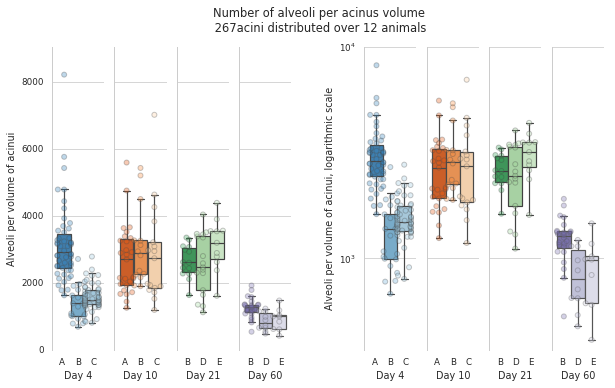

In [72]:
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1,
                2 * len(pandas.unique(Data.Day)) + 1,
                c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Counts per Volume',
                            hue='Animal',
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.swarmplot(data=Data.loc[Data.Day == d], x='Day', y='Counts per Volume',
                                hue='Animal',
#                                 jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
    plt.gca().get_legend().remove()
    plt.ylim([0, 1.1 * Data['Counts per Volume'].max()])
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               [animal[-1] for animal in sorted(Data[Data.Day == d].Animal.unique())])
    plt.xlabel('Day %s' % d)
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Alveoli per volume of acinui')
    plt.subplot(1,
                2 * len(pandas.unique(Data.Day)) + 1,
                len(pandas.unique(Data.Day)) + c + 2)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                               x='Day',
                               y='Counts per Volume',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                               palette=ourpalette,
                               fliersize=0)
    swrmplt = seaborn.swarmplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Counts per Volume',
                                hue='Animal',
#                                 jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,                                
                                alpha=0.309)
    plt.gca().get_legend().remove()
    plt.gca().set_yscale('log')
    # If we set with the 'global' values, there are not enough y-ticks
    # plt.ylim([numpy.min(Data['Counts per Volume'].min()) * 0.9,
    #           numpy.max(Data['Counts per Volume'].max()) * 1.1])
    # We thus manually set the upper range for the logarithmic plot
    plt.ylim([numpy.min(Data['Counts per Volume'].min()) * 0.9,
              1e4])
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3),
               [animal[-1] for animal in sorted(Data[Data.Day == d].Animal.unique())])
    plt.xlabel('Day %s' % d)
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Alveoli per volume of acinui, logarithmic scale')
plt.suptitle('Number of alveoli per acinus volume\n '
             '% sacini distributed over %s animals' % (len(Data),
                                                       len(pandas.unique(Data.Animal))))
plt.savefig(os.path.join(OutputDir,
                         'Fig04-counts_per_volume.png'))
plt.show()

In [73]:
Data['Counts per Volume normalized'] = numpy.nan
for c, row in Data.iterrows():
    Data.loc[c, 'Counts per Volume normalized'] = row['Counts per Volume'] / numpy.nanmax(Data.loc[Data.Animal == row.Animal]['Counts per Volume'])

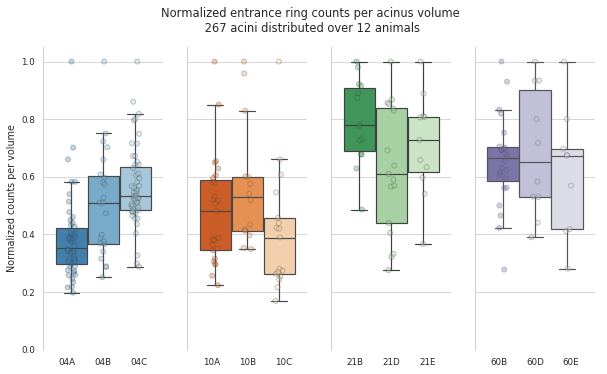

In [74]:
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, len(pandas.unique(Data.Day)), c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Counts per Volume normalized',
                            hue='Animal',
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Counts per Volume normalized',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                alpha=0.309)
    plt.gca().get_legend().remove()
    plt.ylim([0, 1.05])
    plt.xticks(numpy.arange(-0.3, 0.6, 0.3), sorted(Data[Data.Day == d].Animal.unique()))
    plt.xlabel('')
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Normalized counts per volume')
plt.suptitle('Normalized entrance ring counts per acinus volume\n '
             '%s acini distributed over %s animals' % (len(Data),
                                                       len(pandas.unique(Data.Animal))))
plt.savefig(os.path.join(OutputDir, 'counts_per_volume-normalized.png'))
plt.show()

In [75]:
# Are the 'counts' per volume normally distributed?
# Let's perform the Shapiro-Wilk test for normality.
print('The counts per volume for')
for animal in sorted(Data.Animal.unique()):
    w, p_value = scipy.stats.shapiro(Data[Data.Animal == animal]['Counts per Volume'])
    if p_value < sidak:
        # Use the 'significance' function we defined at the start
        print('\t- animal %s (mean=%0.1f) are normally distributed (%s)' % (animal,
                                                                            numpy.mean(Data[Data.Animal == animal]['Counts per Volume']),
                                                                            significance(p_value)))
    else:
        print('\t- animal %s (mean=%0.1f) are non-normally distributed (%s)' % (animal,
                                                                                numpy.mean(Data[Data.Animal == animal]['Counts per Volume']),
                                                                                significance(p_value)))

The counts per volume for
	- animal 04A (mean=3141.6) are normally distributed (**** (p=5.2e-06))
	- animal 04B (mean=1362.8) are non-normally distributed (n.s. (p=0.17))
	- animal 04C (mean=1569.0) are non-normally distributed (* (p=0.015))
	- animal 10A (mean=2684.6) are non-normally distributed (* (p=0.04))
	- animal 10B (mean=3091.4) are non-normally distributed (* (p=0.026))
	- animal 10C (mean=2847.8) are non-normally distributed (* (p=0.014))
	- animal 21B (mean=2642.3) are non-normally distributed (n.s. (p=0.72))
	- animal 21D (mean=2533.7) are non-normally distributed (n.s. (p=0.35))
	- animal 21E (mean=3119.0) are non-normally distributed (n.s. (p=0.96))
	- animal 60B (mean=1249.4) are non-normally distributed (n.s. (p=0.66))
	- animal 60D (mean=837.8) are non-normally distributed (n.s. (p=0.34))
	- animal 60E (mean=898.5) are non-normally distributed (n.s. (p=0.88))


In [76]:
# Let's test if we can assume independent samples.
# For this we compute the Kruskal-Wallis H-test for independent samples
statisctic, p_value = scipy.stats.kruskal(Data[Data.Day == 4]['Counts per Volume'],
                                          Data[Data.Day == 10]['Counts per Volume'],
                                          Data[Data.Day == 21]['Counts per Volume'],
                                          Data[Data.Day == 60]['Counts per Volume'])
if p_value < sidak:
    print('The counts per volume per animal are independent (%s)' % significance(p_value))
else:
    print('We can *not* do what we do below :)')

The counts per volume per animal are independent (**** (p=3.2e-21))


In [77]:
# Let's set ourselves up with an iterator to test all 6 possible combinations
combinations = itertools.combinations(sorted(Data.Day.unique()), 2)
# We have six combinations
worst_p = numpy.nan
for c, combination in enumerate(combinations):
    print('Testing combination %s:' % (c + 1), end=' ')
    print('Day {0[0]} versus day {0[1]}'.format(combination), end=' ')
    print('(means: %.f cpv vs. %.f cpv)' % (numpy.mean(Data[Data.Day == combination[0]]['Counts per Volume']),
                                            numpy.mean(Data[Data.Day == combination[1]]['Counts per Volume'])), end=' ')
    u, p_value = scipy.stats.mannwhitneyu(Data[Data.Day == combination[0]]['Counts per Volume'],
                                          Data[Data.Day == combination[1]]['Counts per Volume'],
                                          alternative='two-sided')
    if p_value < sidak:
        print('is significant (%s)' % significance(p_value))
        worst_p = numpy.nanmax((worst_p, p_value))
    else:
        print('is *not* significant (%s)' % significance(p_value))
print('\nThe worst p_value of all those is %0.2g' % worst_p)

Testing combination 1: Day 4 versus day 10 (means: 2165 cpv vs. 2831 cpv) is significant (**** (p=2.1e-05))
Testing combination 2: Day 4 versus day 21 (means: 2165 cpv vs. 2723 cpv) is significant (**** (p=5.4e-05))
Testing combination 3: Day 4 versus day 60 (means: 2165 cpv vs. 1080 cpv) is significant (**** (p=2.9e-13))
Testing combination 4: Day 10 versus day 21 (means: 2831 cpv vs. 2723 cpv) is *not* significant (n.s. (p=0.7))
Testing combination 5: Day 10 versus day 60 (means: 2831 cpv vs. 1080 cpv) is significant (**** (p=2.9e-16))
Testing combination 6: Day 21 versus day 60 (means: 2723 cpv vs. 1080 cpv) is significant (**** (p=7.2e-14))

The worst p_value of all those is 5.4e-05


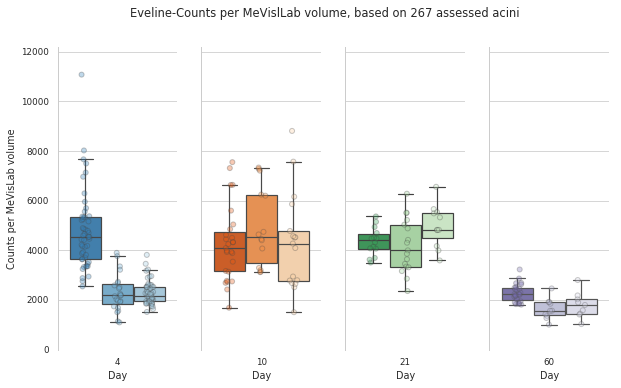

In [78]:
for c, d in enumerate(sorted(pandas.unique(Data.Day))):
    plt.subplot(1, len(pandas.unique(Data.Day)), c + 1)
    bxplt = seaborn.boxplot(data=Data.loc[Data.Day == d],
                            x='Day',
                            y='Counts per MeVisLab Volume',
                            hue='Animal',
                            hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                            palette=ourpalette,
                            fliersize=0)
    swrmplt = seaborn.stripplot(data=Data.loc[Data.Day == d],
                                x='Day',
                                y='Counts per MeVisLab Volume',
                                hue='Animal',
                                jitter=True,
                                hue_order=sorted(pandas.unique(Data.loc[Data.Day == d]['Animal'])),
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette, 
                                alpha=0.309)
    plt.ylim([0, 1.1 * Data['Counts per MeVisLab Volume'].max()])
    plt.gca().get_legend().remove()    
    if c:
        plt.ylabel('')
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Counts per MeVisLab volume')
plt.suptitle('Eveline-Counts per MeVislLab volume, based on %s assessed acini' % len(Data))
plt.savefig(os.path.join(OutputDir, 'counts_per_mevislab_volume.pdf'))
plt.show()

In [79]:
# See maximal and minimal acinus
Data.loc[Data['Counts per Volume'] == max(Data['Counts per Volume'])]

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,...,Location_Volume,Filename_Volume,Volume_Acinus_MeVisLab,Counts_Eveline_normalized,Volume_Acinus_MeVisLab_normalized,Volume_Acinus_STEPanizer_normalized,ImageCountDifference,Counts per Volume,Counts per MeVisLab Volume,Counts per Volume normalized
34,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At...,_R108C04At-mrg-acinus43_2013-04-02_14-02_resul...,2010a,R108C04At-mrg,04A,4,43,35.0,0.22,28,...,\\anatera4\share\SLS\2010a\mrg\R108C04At-mrg\R...,R108C04At-mrg.2936x2936x1024.gvr.acinus43.volu...,0.003161,0.315315,0.146899,0.122163,0,8207.959673,11073.600783,1.0


In [80]:
Data.loc[Data['Counts per Volume'] == min(Data['Counts per Volume'])]

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,...,Location_Volume,Filename_Volume,Volume_Acinus_MeVisLab,Counts_Eveline_normalized,Volume_Acinus_MeVisLab_normalized,Volume_Acinus_STEPanizer_normalized,ImageCountDifference,Counts per Volume,Counts per MeVisLab Volume,Counts per Volume normalized
14,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Et...,_R108C60Et-mrg-acinus08_2012-09-27_13-47_resul...,2009f,R108C60Et-mrg,60E,60,8,770.0,2.17,141,...,\\anatera4\share\SLS\2009f\mrg\R108C60Et-mrg\R...,R108C60Et-mrg.2444.2944.1024.gvr.acinus8.volum...,0.752025,0.639535,1.0,1.0,0,410.751566,1023.901954,0.280696


----

# Estimation of mean number of alveoli per acinus.
Calculated from global values from Stefan and Sebastien.

In [81]:
# Number of acini averaged from Barre2016 (5865@day4, table 3) and Barre2014 (5943@day60, table 2)
BarreNumberOfAciniDay = [5865, numpy.nan, numpy.nan, 5943]
BarreNumberOfAcini = numpy.nanmean(BarreNumberOfAciniDay)

In [82]:
# Number of alveoli from Tschanz2014, Table 1, p. 91)
StefanNumberOfAlveoli = [0.823,
                         3.538,
                         14.303,
                         # 14.615,
                         19.279]
StefanNumberOfAlveoli = [n * 1e6 for n in StefanNumberOfAlveoli]

In [83]:
# Number of alveoli from Tschanz2014, Table 1, p. 91 or Datenblattstefan.xls
StefanLungVolume = [1.03,
                    1.81,
                    3.61,
                    # 7.28,
                    10.21]  # cm^3
StefanLungVolume = [v * 1e12 for v in StefanLungVolume]
StefanAlveolarAirspace = [0.486,
                          0.880,
                          1.910,
                          # 3.956,
                          5.645]  # cm^3
StefanAlveolarAirspace = [airspace * 1e12 for airspace in StefanAlveolarAirspace]

In [84]:
# This gives (approximately) the same values as the last column of Table 1
for d, i in zip(sorted(Data.Day.unique()),
                numpy.divide(StefanAlveolarAirspace, StefanNumberOfAlveoli)):
    print('Day %02s: Mean volume of one alveolus from Stefans data: %0.0f um^3' % (d, i))

Day  4: Mean volume of one alveolus from Stefans data: 590522 um^3
Day 10: Mean volume of one alveolus from Stefans data: 248728 um^3
Day 21: Mean volume of one alveolus from Stefans data: 133538 um^3
Day 60: Mean volume of one alveolus from Stefans data: 292806 um^3


In [85]:
# From Datenblattstefan.xls we copy the mean parenchymal volume
# Uncorrected
V_lung_par = [[0.81, 0.77, 0.92],  # d04
              [1.68, 1.72, 1.23],  # d10
              [3.46, 3.25, 2.64],  # d21
              [8.41, 9.41, 9.54]]  # d60
# And convert it from cubic centimeter to cubic millimeter, which everything else is in.
# https://www.google.com/search?hl=en&q=cubic%20centimeter%20to%20cubic%20millimeter
V_lung_par = [numpy.multiply(v, 1000) for v in V_lung_par]
# Corrected with Stefans Shrinkagefactor
ShrinkageFactorPerLung = [[0.477, 0.381, 0.393],  # d04
                          [0.335, 0.372, 0.304],  # d10
                          [0.377, 0.314, 0.413],  # d21
                          [0.373, 0.329, 0.411]]  # d60
# Correct with the shrinking factor
V_lung_par_corr = numpy.multiply(V_lung_par,
                                 ShrinkageFactorPerLung)

Now that we have some data from Stefan and Sebastien, we calculate
- the mean number of alveoli per acinus
- the mean volume of one acinus
- the mean volume of one alveolus

In [86]:
# Calculate the mean acinus volume and reshape into an array we can use
V_az = Data.groupby(by='Animal')['Volume_Acinus_STEPanizer'].mean().values.reshape(4, 3)

In [87]:
# Data.groupby(by='Animal')['Volume_Acinus_STEPanizer'].describe()

In [88]:
# By dividing the parenchymal volume by the acinar volume we get the number of acini
NumberOfAcini = numpy.divide(V_lung_par_corr,
                             V_az)
print('In the mean (%0.0f), we have about %0.2f times more '
      'acini than what Sebastien has (%0.0f)...' % (numpy.mean(NumberOfAcini),
                                                    numpy.mean(NumberOfAcini) / BarreNumberOfAcini,
                                                    BarreNumberOfAcini))

In the mean (11992), we have about 2.03 times more acini than what Sebastien has (5904)...


In [89]:
# Our estimation
print('We have:')
for c, i in enumerate(NumberOfAcini):
    print('Day %02s: %5.0f +- %5.0f acini' % (sorted(Data.Day.unique())[c],
                                              numpy.mean(i),
                                              numpy.std(i)))

We have:
Day  4: 18129 +- 16370 acini
Day 10: 14359 +-  5611 acini
Day 21: 11203 +-  2681 acini
Day 60:  4277 +-   777 acini


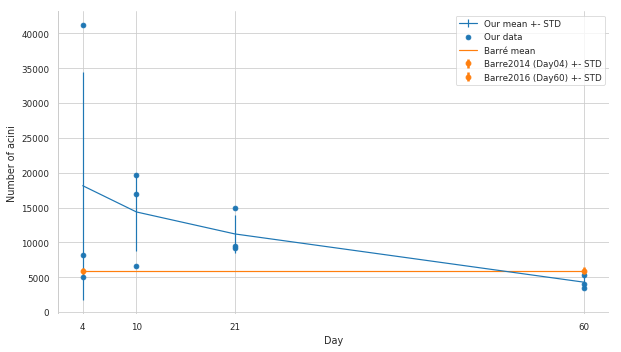

In [90]:
# Display our number of acini in comparison with the ones from Sebastien
# Ours
plt.scatter(numpy.repeat(sorted(Data.Day.unique()), 3),
            NumberOfAcini,
            label='Our data')
plt.errorbar(sorted(Data.Day.unique()),
             [numpy.mean(na) for na in NumberOfAcini],
             yerr=[numpy.std(na) for na in NumberOfAcini],
            label='Our mean +- STD')
# Barré
plt.plot(sorted(Data.Day.unique()),
         [BarreNumberOfAcini] * len(Data.Day.unique()),
         marker=None,
         label='Barré mean')
plt.errorbar(4,
             5865,
             yerr=465,
             fmt='o',
             elinewidth=2.5,
             label='Barre2014 (Day04) +- STD',c=seaborn.color_palette()[1])
plt.errorbar(60,
             5943,
             yerr=521,
             fmt='o',
             elinewidth=2.5,
             label='Barre2016 (Day60) +- STD',c=seaborn.color_palette()[1])
# Specific legend order based on https://stackoverflow.com/a/46160465/323100
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0, 3, 4]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order])
plt.xticks(sorted(Data.Day.unique()))
plt.xlabel('Day')
plt.ylabel('Number of acini')
plt.savefig(os.path.join(OutputDir,
                         'number_of_acini.png'))
plt.show()

In [91]:
# Mean values Tschanz/Barré
TschanzBarreAlveoliPerAcinus = [None] * len(Data.Day.unique())
TschanzBarreAcinarVolume = [None] * len(Data.Day.unique())
TschanzBarreAlveolarVolume = [None] * len(Data.Day.unique())
print('Based on Tschanz2014 and Barre2014/16')
for c, d in enumerate(sorted(Data.Day.unique())):
    TschanzBarreAlveoliPerAcinus[c] = StefanNumberOfAlveoli[c] / BarreNumberOfAcini
    print('At day %s' % d)
    print('\t we have about %0.f alveoli per acinus.' % TschanzBarreAlveoliPerAcinus[c])
    TschanzBarreAcinarVolume[c] = StefanLungVolume[c] / BarreNumberOfAcini
    print('\t with one acinus having a volume of %0.3g um^3.' % TschanzBarreAcinarVolume[c])
    TschanzBarreAlveolarVolume[c] = StefanAlveolarAirspace[c] / StefanNumberOfAlveoli[c]
    print('\t with one alveolus having a volume of %0.3g um^3.' % TschanzBarreAlveolarVolume[c])

Based on Tschanz2014 and Barre2014/16
At day 4
	 we have about 139 alveoli per acinus.
	 with one acinus having a volume of 1.74e+08 um^3.
	 with one alveolus having a volume of 5.91e+05 um^3.
At day 10
	 we have about 599 alveoli per acinus.
	 with one acinus having a volume of 3.07e+08 um^3.
	 with one alveolus having a volume of 2.49e+05 um^3.
At day 21
	 we have about 2423 alveoli per acinus.
	 with one acinus having a volume of 6.11e+08 um^3.
	 with one alveolus having a volume of 1.34e+05 um^3.
At day 60
	 we have about 3265 alveoli per acinus.
	 with one acinus having a volume of 1.73e+09 um^3.
	 with one alveolus having a volume of 2.93e+05 um^3.


In [92]:
# Mean values Eveline/David
MeanAlveolarVolume = [None] * len(Data.Day.unique())
MeanAcinarVolume = [None] * len(Data.Day.unique())
MeanCounts = [None] * len(Data.Day.unique())
print('Based on the stereological estimation from Eveline and David')
for c, d in enumerate(sorted(Data.Day.unique())):
    print('At day %s' % d)    
    MeanCounts[c] = numpy.mean(Data.loc[Data.Day == d]['Counts_Eveline'])
    print('\t we have about %0.f alveoli per acinus.' % MeanCounts[c])
    # Acinus volume (*including* Ductus...), converted  from mm^3  to um^3
    # https://encrypted.google.com/search?hl=en&q=cubic%20millimeter%20to%20cubic%20micrometer
    WithShrinkageCorrection = True
    if WithShrinkageCorrection:
        vol = numpy.mean(Data.loc[Data.Day == d]['Volume_Acinus_STEPanizer']) * 1e9 * numpy.mean(ShrinkageFactorPerLung[c])
    else:
        vol = numpy.mean(Data.loc[Data.Day == d]['Volume_Acinus_STEPanizer']) * 1e9
    CorrectDuctal = False
    if CorrectDuctal:
        # Remove the ductal airspace, as assessed by Tschanz2014
        MeanAcinarVolume[c] = vol - (DuctalToAlveolar[c] * vol)
    else:
        MeanAcinarVolume[c] = vol
    print('\t with one acinus having a volume of %0.3g um^3.' % MeanAcinarVolume[c])
    MeanAlveolarVolume[c] = MeanAcinarVolume[c] / MeanCounts[c]
    print('\t with one alveolus having a volume of %0.3g um^3.' % MeanAlveolarVolume[c])    

Based on the stereological estimation from Eveline and David
At day 4
	 we have about 48 alveoli per acinus.
	 with one acinus having a volume of 1.37e+07 um^3.
	 with one alveolus having a volume of 2.86e+05 um^3.
At day 10
	 we have about 89 alveoli per acinus.
	 with one acinus having a volume of 1.35e+07 um^3.
	 with one alveolus having a volume of 1.52e+05 um^3.
At day 21
	 we have about 233 alveoli per acinus.
	 with one acinus having a volume of 3.82e+07 um^3.
	 with one alveolus having a volume of 1.64e+05 um^3.
At day 60
	 we have about 702 alveoli per acinus.
	 with one acinus having a volume of 2.74e+08 um^3.
	 with one alveolus having a volume of 3.91e+05 um^3.


In [93]:
for c, d in enumerate(sorted(Data.Day.unique())):
    print('Day %02s: Our counts (%6.2f) are %4.1f times lower '
          'than the mean estimation from Tschanz/Barre (%7.2f)'
          % (d,
             Data.loc[Data.Day == d]['Counts_Eveline'].mean(),
          numpy.divide(TschanzBarreAlveoliPerAcinus,
                       [Data.loc[Data.Day == d]['Counts_Eveline'].mean() for d in sorted(Data.Day.unique())])[c],
          TschanzBarreAlveoliPerAcinus[c]))

Day  4: Our counts ( 47.85) are  2.9 times lower than the mean estimation from Tschanz/Barre ( 139.40)
Day 10: Our counts ( 88.53) are  6.8 times lower than the mean estimation from Tschanz/Barre ( 599.25)
Day 21: Our counts (233.33) are 10.4 times lower than the mean estimation from Tschanz/Barre (2422.59)
Day 60: Our counts (701.79) are  4.7 times lower than the mean estimation from Tschanz/Barre (3265.41)


In [94]:
print('On average, we are %0.1f times lower' %
      numpy.mean(numpy.divide(TschanzBarreAlveoliPerAcinus,
                              [Data.loc[Data.Day == d]['Counts_Eveline'].mean() for d in sorted(Data.Day.unique())])[c]))

On average, we are 4.7 times lower


In [95]:
MeanCountsAnimal = Data.groupby('Animal')['Counts_Eveline'].mean().values.reshape(4, 3)

In [96]:
NumberOfAlveoli = NumberOfAcini * MeanCountsAnimal

In [97]:
# Stefans data
print('Stefan has:')
for c, i in enumerate(StefanNumberOfAlveoli):
    print('Day %02s: %5.2f million alveoli' % (sorted(Data.Day.unique())[c],
                                               i * 1e-6))

Stefan has:
Day  4:  0.82 million alveoli
Day 10:  3.54 million alveoli
Day 21: 14.30 million alveoli
Day 60: 19.28 million alveoli


In [98]:
# Our estimation
print('We get:')
for c, i in enumerate(NumberOfAlveoli):
    print('Day %02s: %5.2f +- %0.2f million alveoli' % (sorted(Data.Day.unique())[c],
                                                        numpy.mean(i) * 1e-6,
                                                        numpy.std(i) * 1e-6))

We get:
Day  4:  0.64 +- 0.34 million alveoli
Day 10:  1.23 +- 0.39 million alveoli
Day 21:  2.65 +- 0.57 million alveoli
Day 60:  3.01 +- 0.58 million alveoli


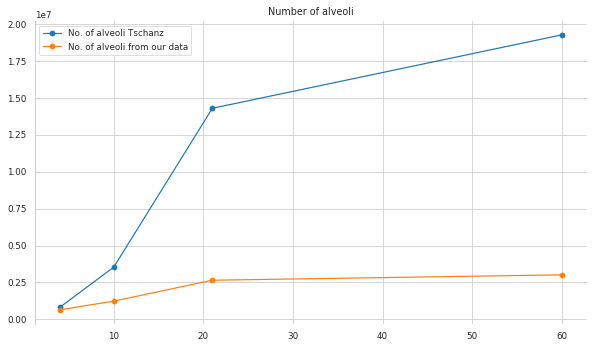

In [99]:
# Plot the Tschanz alveoli vs. our estimation
plt.plot(sorted(Data.Day.unique()),
         StefanNumberOfAlveoli,
         marker='o',
         label='No. of alveoli Tschanz')
plt.plot(sorted(Data.Day.unique()),
         [numpy.mean(na) for na in NumberOfAlveoli],
         marker='o',
         label='No. of alveoli from our data')
plt.legend()
plt.title('Number of alveoli')
plt.savefig(os.path.join(OutputDir,
                         'number_of_alveoli.png'))
plt.show()

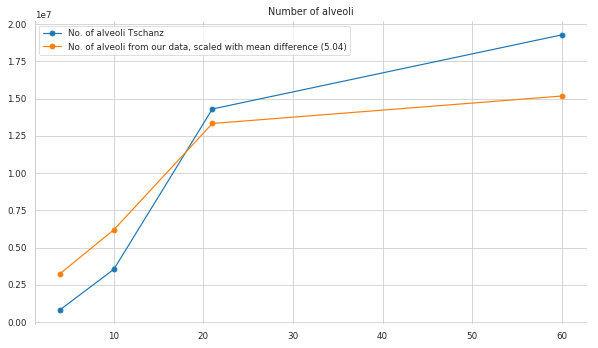

In [100]:
# Plot the Tschanz alveoli vs. our estimation
plt.plot(sorted(Data.Day.unique()),
         StefanNumberOfAlveoli,
         marker='o',
         label='No. of alveoli Tschanz')
plt.plot(sorted(Data.Day.unique()),
         [numpy.mean(na) * numpy.mean(StefanNumberOfAlveoli) / numpy.mean(NumberOfAlveoli) for na in NumberOfAlveoli],
         marker='o',
         label='No. of alveoli from our data, scaled with mean difference (%0.2f)' % (numpy.mean(StefanNumberOfAlveoli) / numpy.mean(NumberOfAlveoli)))
plt.legend()
plt.title('Number of alveoli')
plt.savefig(os.path.join(OutputDir,
                         'number_of_alveoli_mean_scaled.png'))
plt.show()

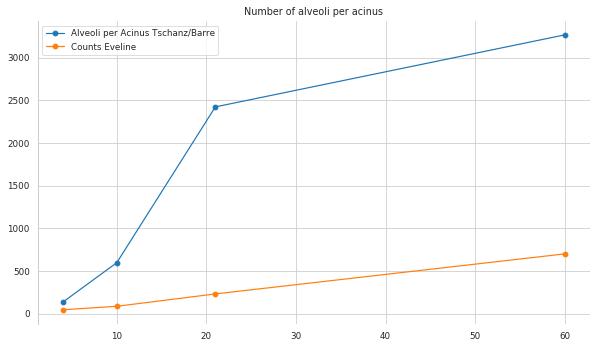

In [101]:
# Plot the Tschanz/Barre alveoli per acinus estimation vs. Evelines counts
plt.plot(sorted(Data.Day.unique()),
         TschanzBarreAlveoliPerAcinus,
         marker='o',
         label='Alveoli per Acinus Tschanz/Barre')
plt.plot(sorted(Data.Day.unique()),
         [Data.loc[Data.Day == d]['Counts_Eveline'].mean() for d in sorted(Data.Day.unique())],
         marker='o',
         label='Counts Eveline')
plt.legend()
plt.title('Number of alveoli per acinus')
plt.savefig(os.path.join(OutputDir,
                         'number_of_alveoli_per_acinus.png'))
plt.show()

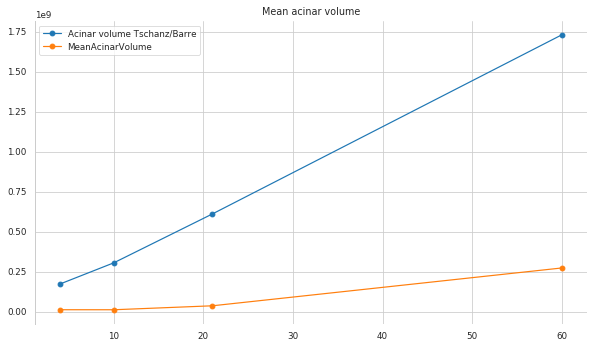

In [102]:
# Plot the Tschanz/Barre acinar volumes vs. ours
plt.plot(sorted(Data.Day.unique()),
         TschanzBarreAcinarVolume,
         marker='o',
         label='Acinar volume Tschanz/Barre')
plt.plot(sorted(Data.Day.unique()),
         MeanAcinarVolume,
         marker='o',
         label='MeanAcinarVolume')
plt.legend()
plt.title('Mean acinar volume')
plt.savefig(os.path.join(OutputDir,
                         'mean_acinar_volume.png'))
plt.show()

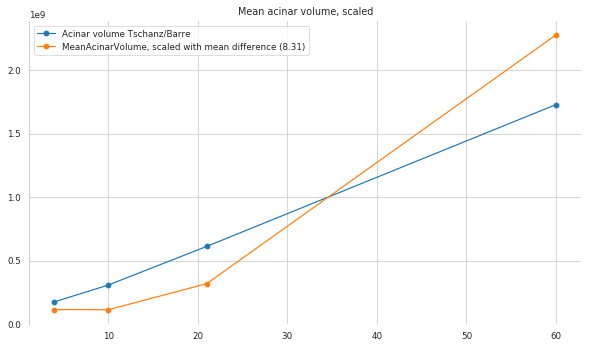

In [103]:
# Plot the Tschanz/Barre acinar volumes vs. ours
plt.plot(sorted(Data.Day.unique()),
         TschanzBarreAcinarVolume,
         marker='o',
         label='Acinar volume Tschanz/Barre')
plt.plot(sorted(Data.Day.unique()),
         [ma * numpy.mean(TschanzBarreAcinarVolume) / numpy.mean(MeanAcinarVolume) for ma in MeanAcinarVolume],
         marker='o',
label='MeanAcinarVolume, scaled with mean difference (%0.2f)' % (numpy.mean(TschanzBarreAcinarVolume) / numpy.mean(MeanAcinarVolume)))
plt.legend()
plt.title('Mean acinar volume, scaled')
plt.savefig(os.path.join(OutputDir, 'mean_acinar_volume_scaled.png'))
plt.show()

In [104]:
numpy.mean(TschanzBarreAcinarVolume) / numpy.mean(MeanAcinarVolume)  

8.305830439858441

In [105]:
for c, d in enumerate(sorted(Data.Day.unique())):
    print('Day %02s: Our mean acinar volumes (%0.3g) are %4.1f times '
          'lower than the volumes from Tschanz/Barre (%0.3g)'
          % (d,
          MeanAcinarVolume[c],
          numpy.divide(TschanzBarreAcinarVolume[c],
                       MeanAcinarVolume[c]),
          TschanzBarreAcinarVolume[c]))

Day  4: Our mean acinar volumes (1.37e+07) are 12.7 times lower than the volumes from Tschanz/Barre (1.74e+08)
Day 10: Our mean acinar volumes (1.35e+07) are 22.7 times lower than the volumes from Tschanz/Barre (3.07e+08)
Day 21: Our mean acinar volumes (3.82e+07) are 16.0 times lower than the volumes from Tschanz/Barre (6.11e+08)
Day 60: Our mean acinar volumes (2.74e+08) are  6.3 times lower than the volumes from Tschanz/Barre (1.73e+09)


In [106]:
print('On average, we are %0.1f times lower' %
      numpy.mean(numpy.divide(TschanzBarreAcinarVolume,
                              MeanAcinarVolume)))

On average, we are 14.4 times lower


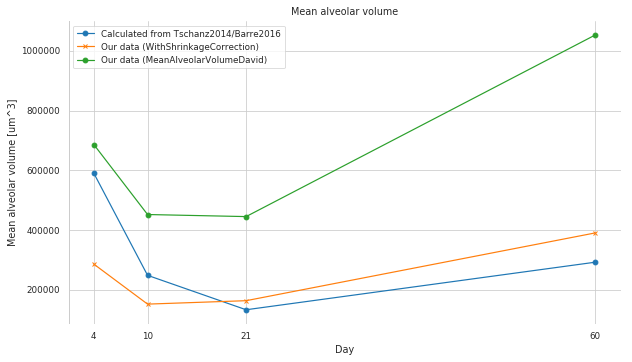

In [107]:
# Plot the mean alveolar volume
plt.plot(sorted(Data.Day.unique()),
         TschanzBarreAlveolarVolume,
         marker='o',
         label='Calculated from Tschanz2014/Barre2016')
plt.plot(sorted(Data.Day.unique()),
         MeanAlveolarVolume,
         marker='x',
         label='Our data (WithShrinkageCorrection)')
plt.plot(sorted(Data.Day.unique()),
         MeanAlveolarVolumeDavid,
         marker='o',
         label='Our data (MeanAlveolarVolumeDavid)')
plt.legend(loc='best')
plt.xticks(Data.Day.unique())
plt.xlabel('Day')
plt.ylabel('Mean alveolar volume [um^3]')
plt.title('Mean alveolar volume')
plt.savefig(os.path.join(OutputDir, 'alveolar_volume.png'))
plt.show()

In [108]:
# Our estimation
print('Stefan has:')
for c, i in enumerate(TschanzBarreAlveolarVolume):
    print('Day %02s: %5.0f um^3 mean alveolar volume' % (sorted(Data.Day.unique())[c],
                                                         numpy.mean(i)))
# No STD possible...

Stefan has:
Day  4: 590522 um^3 mean alveolar volume
Day 10: 248728 um^3 mean alveolar volume
Day 21: 133538 um^3 mean alveolar volume
Day 60: 292806 um^3 mean alveolar volume


In [109]:
# Our estimation
print('We get:')
for c, i in enumerate(MeanAlveolarVolume):
    print('Day %02s: %5.0f um^3 mean alveolar volume' % (sorted(Data.Day.unique())[c],
                                                                  numpy.mean(i)))
# No STD possible...    

We get:
Day  4: 286314 um^3 mean alveolar volume
Day 10: 152420 um^3 mean alveolar volume
Day 21: 163897 um^3 mean alveolar volume
Day 60: 390858 um^3 mean alveolar volume


In [110]:
for c, d in enumerate(sorted(Data.Day.unique())):
    print('Day %02s: Our mean alveolar volumes (%0.3g) are %4.1f times '
          'lower than the volumes from Tschanz/Barre (%0.3g)'
          % (d,
             MeanAlveolarVolume[c],
             numpy.divide(TschanzBarreAlveolarVolume[c],
                          MeanAlveolarVolume[c]),
             TschanzBarreAlveolarVolume[c]))

Day  4: Our mean alveolar volumes (2.86e+05) are  2.1 times lower than the volumes from Tschanz/Barre (5.91e+05)
Day 10: Our mean alveolar volumes (1.52e+05) are  1.6 times lower than the volumes from Tschanz/Barre (2.49e+05)
Day 21: Our mean alveolar volumes (1.64e+05) are  0.8 times lower than the volumes from Tschanz/Barre (1.34e+05)
Day 60: Our mean alveolar volumes (3.91e+05) are  0.7 times lower than the volumes from Tschanz/Barre (2.93e+05)


In [111]:
print('On average, we are %0.1f times lower' %
      numpy.mean(numpy.divide(TschanzBarreAlveolarVolume,
                              MeanAlveolarVolume)))

On average, we are 1.3 times lower


---

----
Let's calculate the number of alveoli via the total numbers.

In [112]:
# From Datenblattstefan.xls we copy the mean airspace volume
V_lung_airspace_values = [[0.619007, 0.590681, 0.732188, 0.616113, 0.675164],  # d04
                          [1.203810, 1.186750, 0.884237, 1.130176, 1.129899],  # d10
                          [2.576568, 2.568601, 2.310215, 2.388927, 2.024192],  # d21
                          # [5.018464, 4.235915, 4.702459, 4.613889, 4.567723],  # d360, discarded
                          [6.595599, 6.372630, 6.858009, 7.156043, 6.730762]]  # d60
# scale to um^3
V_lung_airspace_values = [[v * 1e12 for v in va] for va in V_lung_airspace_values]
# Calculate mean and STD
V_lung_airspace = [numpy.mean(v) for v in V_lung_airspace_values]
V_lung_airspaceSTD = [numpy.std(v) for v in V_lung_airspace_values]

In [113]:
V_lung_airspace

[646630600000.0, 1106974400000.0, 2373700600000.0, 6742608600000.0]

In [114]:
ShrinkageFactorPerLung[0]

[0.477, 0.381, 0.393]

In [115]:
# Mean alveolar volumes
TotalAlveolarVolume = [None] * len(Data.Day.unique())
TotalAcinarVolume = [None] * len(Data.Day.unique())
TotalCounts = [None] * len(Data.Day.unique())
for c, d in enumerate(sorted(Data.Day.unique())):
    print('Day %s' % d)
    TotalCounts[c] = numpy.sum(Data.loc[Data.Day == d]['Counts_Eveline'])
    print('Total counts: %s' % int(TotalCounts[c]))
    # Acinus volume (*including* Ductus...), converted  from mm^3  to um^3
    # https://encrypted.google.com/search?hl=en&q=cubic%20millimeter%20to%20cubic%20micrometer
    # This volume *needs* to be corrected with the shrinkage factor
    vol = numpy.sum(Data.loc[Data.Day == d]['Volume_Acinus_STEPanizer']) * 1e9 / numpy.mean(ShrinkageFactorPerLung[c])
    CorrectDuctal = False
    if CorrectDuctal:
        # Remove the ductal airspace, as assessed by Tschanz2014
        TotalAcinarVolume[c] = vol - (DuctalToAlveolar[c] * vol)
    else:
        TotalAcinarVolume[c] = vol
    print('Total acinus volume: %0.2g um^3' % numpy.mean(TotalAcinarVolume[c]))
    TotalAlveolarVolume[c] = numpy.mean(TotalAcinarVolume[c]) / TotalCounts[c]
    print('Total alveolar volume: %0.2g um^3' % TotalAlveolarVolume[c])

Day 4
Total counts: 5934
Total acinus volume: 9.8e+09 um^3
Total alveolar volume: 1.6e+06 um^3
Day 10
Total counts: 5135
Total acinus volume: 6.9e+09 um^3
Total alveolar volume: 1.3e+06 um^3
Day 21
Total counts: 9800
Total acinus volume: 1.2e+10 um^3
Total alveolar volume: 1.2e+06 um^3
Day 60
Total counts: 30177
Total acinus volume: 8.6e+10 um^3
Total alveolar volume: 2.8e+06 um^3


In [116]:
# Read mean alveolar volumes from Stefans calculation without ductal volume correction
MeanAlveolarVolumeStefan = pandas.read_excel(glob.glob('*v9*David.xl*')[0],
                                             sheet_name=0,
                                             usecols='T',
                                             skiprows=2)

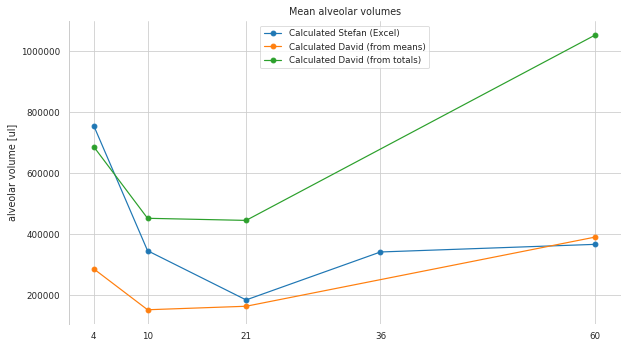

In [117]:
# Plot the mean alveolar volumes
# Stefan also has day 36, so we just append it prior to sorting
plt.plot(sorted(numpy.append(Data.Day.unique(), 36)),
         MeanAlveolarVolumeStefan,
         marker='o',
         label='Calculated Stefan (Excel)')
plt.plot(sorted(Data.Day.unique()),
         MeanAlveolarVolume,
         marker='o',
         label='Calculated David (from means)')
plt.plot(sorted(Data.Day.unique()),
         MeanAlveolarVolumeDavid,
         marker='o',
         label='Calculated David (from totals)')
plt.title('Mean alveolar volumes')
plt.ylabel('alveolar volume [ul]')
plt.xticks(numpy.append(Data.Day.unique(), 36))
plt.legend(loc='upper center')
plt.savefig(os.path.join(OutputDir, 'mean_alveolar_volumes.png'))
plt.show()

In [118]:
MeanAlveolarVolume

[286313.7825291952, 152420.18351480976, 163897.11989345305, 390858.04488824494]

In [119]:
MeanCounts

[47.854838709677416, 88.53448275862068, 233.33333333333334, 701.7906976744187]

In [120]:
V_lung_par

[array([810., 770., 920.]),
 array([1680., 1720., 1230.]),
 array([3460., 3250., 2640.]),
 array([8410., 9410., 9540.])]

In [121]:
Data.groupby(by=['Animal', 'Day'])['Volume_Acinus_STEPanizer'].mean()

Animal  Day
04A     4      0.009375
04B     4      0.058097
04C     4      0.044496
10A     10     0.033345
10B     10     0.032617
10C     10     0.056795
21B     21     0.087002
21D     21     0.108524
21E     21     0.118337
60B     60     0.588268
60D     60     0.888499
60E     60     0.976536
Name: Volume_Acinus_STEPanizer, dtype: float64

In [122]:
N_az_total = numpy.divide(V_lung_par,
                          Data.groupby(by=['Animal',
                                           'Day'])['Volume_Acinus_STEPanizer'].mean().values.reshape((4, 3)))

In [123]:
N_az_total

array([[86396.63859699, 13253.58602684, 20676.01077448],
       [50381.67927579, 52733.11280879, 21656.74103969],
       [39768.99563194, 29947.17347327, 22309.25473587],
       [14296.20780333, 10590.89121786,  9769.22622951]])

In [124]:
for i in N_az_total:
    print('%0.2f e3 Acini pro Lunge' % numpy.mean(i))

40108.75 e3 Acini pro Lunge
41590.51 e3 Acini pro Lunge
30675.14 e3 Acini pro Lunge
11552.11 e3 Acini pro Lunge


In [125]:
N_az_total_corr = numpy.divide(V_lung_par_corr,
                               Data.groupby(by=['Animal',
                                                'Day'])['Volume_Acinus_STEPanizer'].mean().values.reshape((4, 3)))

In [126]:
N_az_total_corr

array([[41211.19661077,  5049.61627622,  8125.67223437],
       [16877.86255739, 19616.71796487,  6583.64927607],
       [14992.91135324,  9403.41247061,  9213.72220592],
       [ 5332.48551064,  3484.40321068,  4015.15198033]])

In [127]:
for i in N_az_total_corr:
    print('%0.2f e3 Acini pro Lunge' % numpy.mean(i))

18128.83 e3 Acini pro Lunge
14359.41 e3 Acini pro Lunge
11203.35 e3 Acini pro Lunge
4277.35 e3 Acini pro Lunge


In [128]:
N_alv_total = numpy.divide(numpy.multiply(Data[['Animal',
                                                'Counts_Eveline']].groupby(by='Animal').mean().values.reshape((4, 3)),
                                          V_lung_par),
                           Data[['Animal',
                                 'Volume_Acinus_STEPanizer']].groupby(by=['Animal']).mean().values.reshape((4, 3)) * 1000)

In [129]:
N_alv_total

array([[ 2336.16510766,   862.05933462,  1251.10135784],
       [ 3922.30703103,  4459.71468326,  2355.48906955],
       [ 8277.63237653,  5869.64600076,  7207.91739375],
       [10032.36382599,  7077.89260089,  7220.54365319]])

In [130]:
for i in N_alv_total:
    print('%0.2f e6 Alveoli pro Lunge' % numpy.mean(i))

1483.11 e6 Alveoli pro Lunge
3579.17 e6 Alveoli pro Lunge
7118.40 e6 Alveoli pro Lunge
8110.27 e6 Alveoli pro Lunge


In [131]:
N_alv_total_corr = numpy.divide(numpy.multiply(Data[['Animal',
                                                     'Counts_Eveline']].groupby(by='Animal').mean().values.reshape((4, 3)),
                                               V_lung_par_corr),
                                Data[['Animal',
                                      'Volume_Acinus_STEPanizer']].groupby(by=['Animal']).mean().values.reshape((4, 3)) * 1000)

In [132]:
N_alv_total_corr

array([[1114.35075636,  328.44460649,  491.68283363],
       [1313.97285539, 1659.01386217,  716.06867714],
       [3120.66740595, 1843.06884424, 2976.86988362],
       [3742.07170709, 2328.62666569, 2967.64344146]])

In [133]:
for i in N_alv_total_corr:
    print('%0.2f e6 Alveoli pro Lunge' % numpy.mean(i))

644.83 e6 Alveoli pro Lunge
1229.69 e6 Alveoli pro Lunge
2646.87 e6 Alveoli pro Lunge
3012.78 e6 Alveoli pro Lunge


In [134]:
N_alv_total

array([[ 2336.16510766,   862.05933462,  1251.10135784],
       [ 3922.30703103,  4459.71468326,  2355.48906955],
       [ 8277.63237653,  5869.64600076,  7207.91739375],
       [10032.36382599,  7077.89260089,  7220.54365319]])

In [135]:
for i in N_alv_total:
    print('%f * 1e6 alveoli' % (numpy.mean(i)))

1483.108600 * 1e6 alveoli
3579.170261 * 1e6 alveoli
7118.398590 * 1e6 alveoli
8110.266693 * 1e6 alveoli


In [136]:
NumberOfAlveoli

array([[1114350.7563551 ,  328444.60648833,  491682.83363268],
       [1313972.85539373, 1659013.86217199,  716068.67714385],
       [3120667.40595286, 1843068.84423888, 2976869.8836203 ],
       [3742071.70709406, 2328626.66569415, 2967643.44146037]])

In [137]:
[numpy.mean(na) * 1e-7 for na in NumberOfAlveoli]

[0.06448260654920387,
 0.12296851315698576,
 0.26468687112706807,
 0.3012780604749525]

In [138]:
[numpy.std(na) for na in NumberOfAlveoli]

[338626.39806316287, 389542.22773446364, 571396.0106834851, 577918.5316846678]

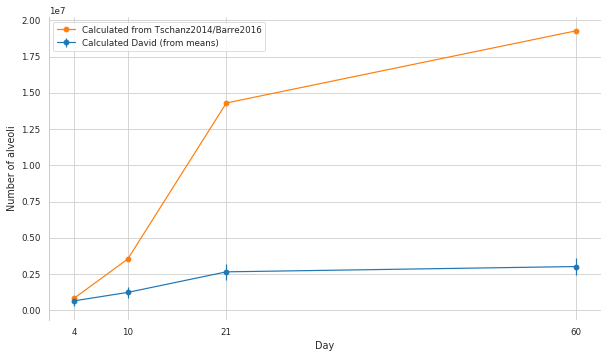

In [139]:
# Number of Alveoli
plt.errorbar(sorted(Data.Day.unique()),
             [numpy.mean(na) for na in NumberOfAlveoli],
             yerr=[numpy.std(na) for na in NumberOfAlveoli],
             marker='o', label='Calculated David (from means)')
plt.plot(sorted(Data.Day.unique()), StefanNumberOfAlveoli, marker='o', label='Calculated from Tschanz2014/Barre2016')
plt.legend(loc='best')
plt.xticks(Data.Day.unique())
plt.xlabel('Day')
plt.ylabel('Number of alveoli')
plt.savefig(os.path.join(OutputDir,
                         'Fig05-number-of-alveoli.png'))
plt.show()

In [140]:
# Save all dataframes to different sheets in one big excel file for Stefan
# This is so that Stefan can take a look at it
# Based on the bottom of https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_excel.html
writer = pandas.ExcelWriter('Data_' + get_git_hash() + '.xlsx')
Data.to_excel(writer, 'All data merged')
Done.to_excel(writer, 'Eveline und David merged')
David.to_excel(writer, 'David')
Eveline.to_excel(writer, 'Eveline')
VolumesFromDisk.to_excel(writer, 'Volumes from MeVisLab')
writer.save()
print('Data file written to', writer.path)

Data file written to Data_f821590.xlsx


In [141]:
# Save all dataframes to different sheets in one big excel file for Stefan
# This is so that Stefan can take a look at it
# Based on the bottom of https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html
writer = pandas.ExcelWriter('Data_Day_' + get_git_hash() + '.xlsx')
# N_V_az (Counts Eveline)
Data.groupby(by=['Day'])['Counts_Eveline'].describe()[['count',
                                                       'mean',
                                                       'std']].to_excel(writer,
                                                                        'N _V_az (Counts_Eveline)')
# ~V_Az (David Cavalieri)
Data.groupby(by=['Day'])['Volume_Acinus_STEPanizer'].describe()[['count',
                                                                 'mean',
                                                                 'std']].to_excel(writer,
                                                                                  '~V_az (David Cavalieri)')
for d in sorted(Data.Day.unique()):
    Data[Data.Day == d][['Location_Eveline',
                         'Location_David',
                         'Sample',
                         'Animal',
                         'Acinus',
                         'Counts_Eveline',
                         'Volume_Acinus_STEPanizer']].to_excel(writer,
                                                               'Detail Daten Tag %s' % d)
writer.save()
print('Data file written to', writer.path)

Data file written to Data_Day_f821590.xlsx


In [142]:
print('Done with everything')

Done with everything


In [143]:
print('Saved all data to', os.path.join(os.getcwd(), OutputDir))

Saved all data to /home/habi/P/Documents/AcinarSize_Johannes/Output/f821590
